## Robot programming workshop 06

<div class="alert alert-block alert-info">For this workshop you will be using a new robot, the dr20, and a new environment, a short 'maze' with a curvy path to get gent out. The dr20 robot had a richer array of sensors than the line-following robot, with <b>4 left and right facing ultrasonic sensors, a front facing laser sensor and a front facing camera</b>. The goal of this workshop is to interface with the robot class and write some code to pilot the robot out of the 'maze'.  At the moment there is no definite end to the 'maze' (emerging from the walled part) so you will have to see if there is any change to the sensors to see if there is a way of detecting this state.  Make sure you have save sim.py, simConst.py (or vrepConst.py) and remoteApi.dll files to a directory and also downloaded the short_path_vrep.ttt to your working folder (a known location)</div>

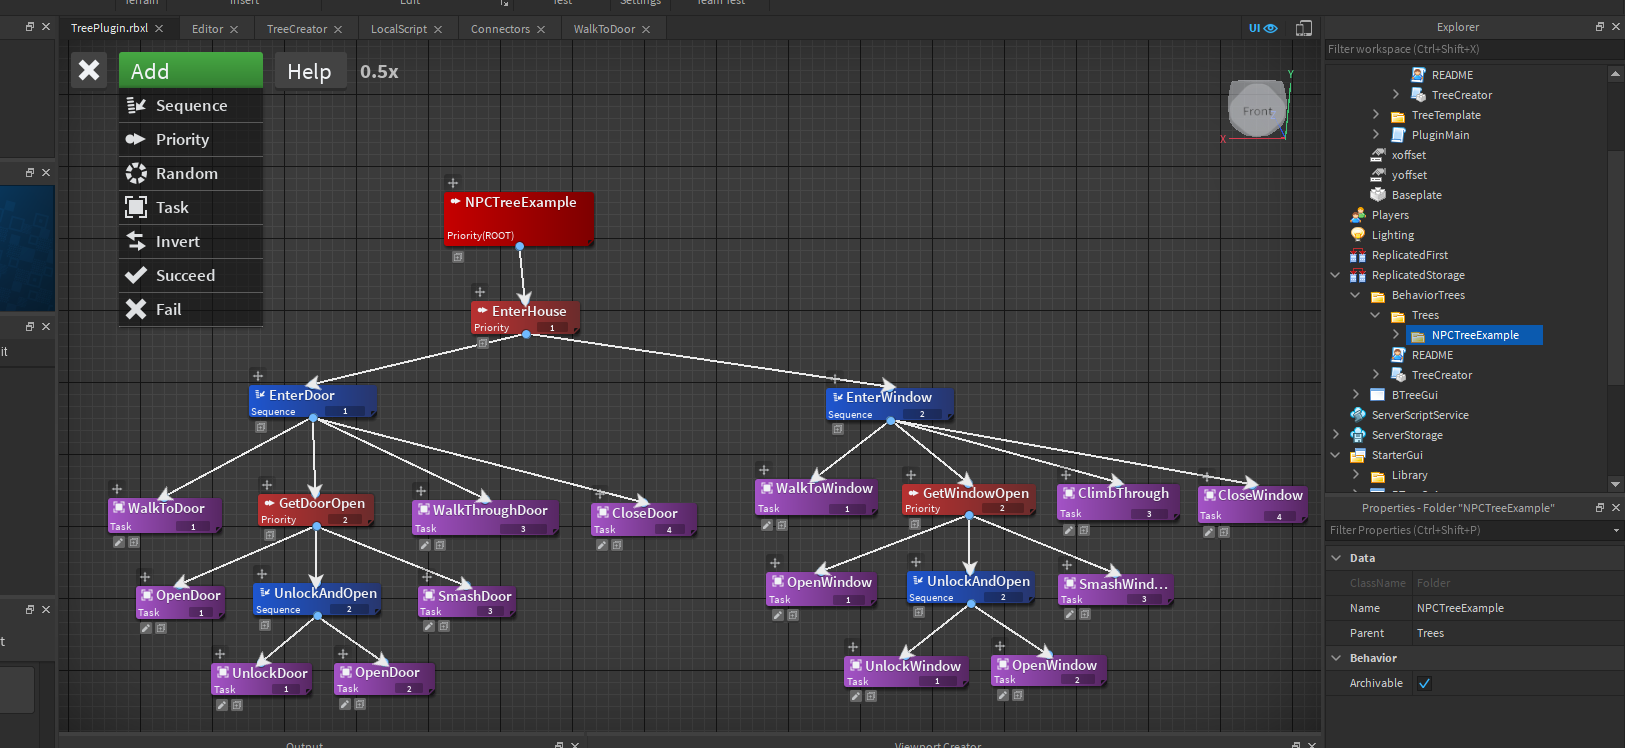

<font color="red"><b>Task 1:</b></font> Download the <b>short_path_vrep.ttt</b> to a working directory where you have saved sim.py, simConst.py (or vrepConst.py) and remoteApi.dll and change your path to that directory.  

In [1]:
import os
desiredPath = "C:\\Users\\User\\OneDrive\\Desktop\\Robotics2\\Robotics\\Robotics\\Files" # "C:/HOME/work/year-21-22/5CS036-sem2/SLAM/Slam-With-V-Rep" # set this path to your working folder
os.chdir(desiredPath)
print("Current working directory: {}".format(os.getcwd()))   # sanity check

try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')

import time
import sys

Current working directory: C:\Users\User\OneDrive\Desktop\Robotics2\Robotics\Robotics\Files


<font color="red"><b>Task 2:</b></font> Load the other libraries we are going to use for this workshop.  

In [2]:
from Dr20Robot import Dr20Robot_Interface

class Dr20Robot(Dr20Robot_Interface):

    def __init__(self, sim, clientID):
        Dr20Robot_Interface.__init__(self, sim, clientID)

    def behaviourTree(self):
        assert False, "Abstract, this method (behaviourTree) should be overridden" 

    def robotBehaviour(self):
        self.behaviour_tree.run()


### Behaviour tree engine

<font color="red"><b>Task 3:</b></font> These classes are the core components of the behaviour tree, they define the structures that the engine is built upon. <b>Note:</b> the interface between the behaviour tree and the Robot needs a scratch pad/buffer/database by which to pass values which is the purpose of the WhiteBoardStatus class.

In [3]:
class WhiteBoardStatus:
    def __init__(self, bot):
        self.robot  = bot  
        self.onLine = False
        self.sensorReading = [None] * 5
        self.behaviour = None
        self.startTime = 0
        
class Leaf:
    def __init__(self):
        pass

    def run(self):
        assert Flase, "Abstract, this method (run) should be overridden"

class Behaviour(Leaf):
    """
   Base class for a node of a Tree Behavior
    """
    def __init__(self):
        Leaf.__init__(self)
        self._children = []

    def run(self):
        pass

    def add_child(self, c):
        self._children.append(c)

    def add_children(self, cs):
        self._children.extend(cs)
        

class Status:
    FAILURE = 0
    SUCCESS = 1
    RUNNING = 2
    STOP    = 4
    

<font color="red"><b>Task 4:</b></font> The actual behaviour tree engine, this contains the classes for selectors, sequence, decorators, etc. Note: there are no concurrent/parallel variants for this implementation. 

In [4]:
import random

class Selector(Behaviour):
    """
    Implementation of the Selector
    """
    def __init__(self):
        Behaviour.__init__(self)
    def run(self):
        for c in self._children:
            status = c.run()
            while status == Status.RUNNING:
                status = c.run()
            if status == Status.SUCCESS:
                return Status.SUCCESS
        return Staus.FAILURE


class Sequence(Behaviour):
    """
    Implementation of the Sequence
    """
    def __init__(self):
        Behaviour.__init__(self)
    def run(self):
        for c in self._children:
            status = c.run()
            while status == Status.RUNNING:
                status = c.run()
            if status == Status.FAILURE:
                return Status.FAILURE
        return Status.SUCCESS

class NDSelector(Selector):
    """
    Implementazione di un Selector
    """
    def __init__(self):
        Selector.__init__(self)

    def add_child(self, c):
        self._children.append(c)
        random.shuffle(self._children)


class NDSequence(Sequence):
    """
    Implementazione di un Sequence
    """
    def __init__(self):
        Sequence.__init__(self)

    def add_child(self, c):
        self._children.append(c)
        random.shuffle(self._children)

class Decorator(Leaf):
    def __init__(self):
        Leaf.__init__(self)
        self._child = None

    def add_child(self, c):
        self._child = c

    def run(self):
        return self._child.run()

<font color="red"><b>Task 5:</b></font> These are the specific behaviours for our robot working in a v-rep/coppiliasim <i>It is complete enough for this weeks workshop demonstration but may need to be edited, for example, to use the full set of sensors on the robot, to complete the workshop task</i>. 

In [5]:
class Stop(Behaviour):
    def __init__(self, status):
        super().__init__()
        self._status = status

    def run(self):
        print('--Stop')
        self._status.robot.stop()
        self._status.behaviour = None
        return Status.SUCCESS

class TurnLeft(Behaviour):
    def __init__(self, status):
        super().__init__()
        self._status = status

    def run(self):
        status = Status.RUNNING
        if self._status.behaviour == None:
            print('--TurnLeft')
            self._status.robot.rotate_left(1.5)
            self._status.startTime=time.time()
            self._status.behaviour = "TurnLeft"
        elif self._status.behaviour == "TurnLeft" and time.time()-self._status.startTime > 2:
            self._status.robot.stop()
            self._status.behaviour = None
            status = Status.SUCCESS
        return status

class TurnRight(Behaviour):
    def __init__(self, status):
        super().__init__()
        self._status = status

    def run(self):
        status = Status.RUNNING
        if self._status.behaviour == None:
            print('--TurnRight')
            self._status.robot.rotate_right(1.5)
            self._status.startTime=time.time()
            self._status.behaviour = "TurnRight"
        elif self._status.behaviour == "TurnRight" and time.time()-self._status.startTime > 2:
            self._status.robot.stop()
            self._status.behaviour = None
            status = Status.SUCCESS
        return status
    
class Movement(Behaviour):
    def __init__(self, status):
        super().__init__()
        self._status = status

    def run(self):
        status = Status.RUNNING
        sensReading = self._status.robot.readSensors()
        self._status.sensReading = sensReading
        front_left = sensReading[0]
        front = sensReading[2]
        front_right = sensReading[3]
        back_left = sensReading[2]
        back_right = sensReading[4]

        print("Sensor Readings:", front_left, front_right, front)

        if front < 0.67:
            if  front_left < front_right:
                self._status.robot.rotate_right(0.8)
                self._status.behaviour = "TurnRight"
                status = Status.RUNNING
            elif front_right < front_left:  
                self._status.robot.rotate_left(0.8)
                self._status.behaviour = "TurnLeft"
                status = Status.RUNNING
                
        else:
            self._status.robot.move_forward(5)
            self._status.behaviour = "Forward"
            status = Status.RUNNING

        return status


class Forward(Behaviour):
    def __init__(self, status):
        super().__init__()
        self._status = status

    def run(self):
        status = Status.RUNNING
        self._status.robot.move_forward(2.0)
        status = Status.SUCCESS
        return status

class ReadSensors(Behaviour):
    def __init__(self, status):
        super().__init__()
        self._status = status

    def run(self):
        self.sensorReading = self._status.robot.readSensors()    
        print(self.sensorReading)
        status = Status.SUCCESS
        return status

class TimeOut(Decorator):
    def __init__(self, child, duration=0):
        Decorator.__init__(self)
        self.add_child(child)
        self.delay = duration

    def run(self):
        status = self._child.run()
        if status == Status.SUCCESS:
            time.sleep(self.delay)
        return Status.SUCCESS

class DoTwice(Decorator):
    def __init__(self, child):
        Decorator.__init__(self)
        self.count = 0
        self.add_child(child)

    def run(self):
        if self.count < 2:
            self.count = self.count + 1
            self._child.run()
            return Status.RUNNING
        self.count = 0
        return Status.SUCCESS

    
class DoUntilClose(Decorator):
    def __init__(self, status, child, distance=0.0):
        Decorator.__init__(self)
        self._status = status
        self.add_child(child)
        self.distance = distance
        self.FixedDelay = 0.5

    def run(self):
        sensorReading = self._status.robot.readSensors()
        if sensorReading[2] < self.distance:
            return Status.SUCCESS
        self._child.run()
        time.sleep(self.FixedDelay)
        return Status.RUNNING


<font color="red"><b>Task 6:</b></font> Again I am using OO design here (inheritance and overriding) to expose the behaviourTree for modification. But it is this code than finally marries together the Robot control and the behaviour tree. <b>Note: the behaviour tree does nothing useful and you will have to implement your own to complete the workshop task</b>

In [6]:
class BTRobot(Dr20Robot):
    def __init__(self, sim, clientID):
        Dr20Robot.__init__(self, sim, clientID)
        self.behaviour_tree = self.behaviourTree()
        
    def behaviourTree(self):
        status = WhiteBoardStatus(self)

        turnRight = TurnRight(status)
        turnLeft =  TurnLeft(status)
        forward =  Forward(status)
        bot = Movement(status)
        

        start = NDSelector()
        root = Sequence()

        start.add_children([forward])
        root.add_children([start, bot])

        return root 

<font color="red"><b>Task 7:</b></font> Implements our interface to v-rep/Coppeliasim and creates the behaviour tree robot ready for running in the simulator. 

In [7]:
def shortPathMain(viewSensors=False, iterations = 8):
    print ('Program started')
    sim.simxFinish(-1) 

    clientID=sim.simxStart('127.0.0.1',19997,True,True,5000,5) 

    if clientID != -1:
        print ('Connected to remote API server')
    else:
        print('Connection failed!!')
        sys.exit('Could not connect')

  
    bot = BTRobot(sim, clientID)
    bot.viewSensors = viewSensors  

 
    for _ in range(iterations):
        bot.robotBehaviour()
        time.sleep(1.0)

    bot.stop()
    time.sleep(0.5)   
    sim.simxFinish(-1)
    print("...done")

Remember to <b>run the v-rep/CoppeliaSim scene first</b> and then run the cell below.

In [8]:
viewSensors = False
try:
    shortPathMain(viewSensors)
except Exception as ex:
    print("Exception was: {}".format(ex))
    sim.simxFinish(-1) 
    print("...uh oh, something went wrong!!!")

Program started
Connected to remote API server
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 0.3298657273398944 1.0 1.0
Sensor Readings: 0.3298444563732609 1.0 1.0
Sensor Readings: 0.32983351572937053 1.0 1.0
Sensor Readings: 0.3298455585769435 1.0 1.0
Sensor Readings: 0.3298737266087808 1.0 1.0
Sensor Readings: 0.3298928597352858 1.0 1.0
Sensor Readings: 0.32990954317821997 1.0 1.0
Sensor Readings: 0.3299295077123638 1.0 1.0
Sensor Readings: 0.3299450003599158 1.0 1.0
Sensor Readings: 0.3299666082831277 1.0 1.0
Sensor Readings: 0.32998705114267396 1.0 1.0
Sensor Readings: 0.3300069960450622 1.0 1.0
Sensor Readings: 0.3300243108255587 1.0 1.0
Sensor Readings: 0.3300438938649915 1.0 1.0
Sensor Readings: 0.3300608560640651 1.0 1.0
Sensor Readings: 0.3300903643316277 1.0 1.0
Sensor Readings: 0.3301072889831214 1.0 1.0
Sensor Readings: 0.3301266921998028 1.0 1.0
Sensor Readings: 0.33014808869455825 1.0 1.0
Sensor Readings: 0.33016608516724477 1.0 1.0
Sensor Readings: 0.33018604386192774 1.

Sensor Readings: 0.15892539178242118 1.0 0.6492202749277186
Sensor Readings: 0.15843800428306917 1.0 0.6436560291658723
Sensor Readings: 0.15656086963671018 1.0 0.6451883295592944
Sensor Readings: 0.15421677129069256 1.0 0.6562293796689468
Sensor Readings: 0.1499453058010733 1.0 0.6537082462702252
Sensor Readings: 0.14801180728635563 1.0 0.6395360663310442
Sensor Readings: 0.14535189984450705 1.0 0.6372324672431864
Sensor Readings: 0.14367724414971364 1.0 0.669565924960246
Sensor Readings: 0.14125840135769183 1.0 0.633195167549656
Sensor Readings: 0.13895666644561655 1.0 0.6322522320801195
Sensor Readings: 0.13748045564809558 1.0 1.0
Sensor Readings: 0.13593327352441278 1.0 1.0
Sensor Readings: 0.13437613697986084 1.0 1.0
Sensor Readings: 0.13402559868921363 1.0 1.0
Sensor Readings: 0.13539562245074602 1.0 1.0
Sensor Readings: 0.13855534229857047 1.0 1.0
Sensor Readings: 0.1423300624960166 1.0 1.0
Sensor Readings: 0.14609104920672378 1.0 1.0
Sensor Readings: 0.15173720120234116 1.0 1.0

Sensor Readings: 0.17371853719607053 1.0 1.0
Sensor Readings: 0.17761127118650513 1.0 1.0
Sensor Readings: 0.18345409957273007 1.0 1.0
Sensor Readings: 0.1873460726821193 1.0 1.0
Sensor Readings: 0.19124450006012156 1.0 1.0
Sensor Readings: 0.19513662039111448 1.0 1.0
Sensor Readings: 0.199029593698758 1.0 1.0
Sensor Readings: 0.20487365022771398 1.0 1.0
Sensor Readings: 0.20876991216309682 1.0 0.9915248065617716
Sensor Readings: 0.21266109004425818 1.0 0.9609414777883575
Sensor Readings: 0.21655140902033904 1.0 0.9517061923155574
Sensor Readings: 0.22045198480107012 1.0 1.0
Sensor Readings: 0.2262978930318282 1.0 0.949159699697413
Sensor Readings: 0.23018955054948426 1.0 0.8591661291396581
Sensor Readings: 0.23408591744417154 1.0 0.8304383493882532
Sensor Readings: 0.23783529341582132 1.0 0.7885922988271525
Sensor Readings: 0.23610117569529304 1.0 1.0
Sensor Readings: 0.23437575739430608 1.0 1.0
Sensor Readings: 0.23264779619493758 1.0 1.0
Sensor Readings: 0.23091937245308877 1.0 1.0


Sensor Readings: 0.17549558247632743 1.0 0.910915427128705
Sensor Readings: 0.17649773876758743 1.0 1.0
Sensor Readings: 0.17750167962824115 1.0 0.8610711816161363
Sensor Readings: 0.16264173647495317 1.0 0.8445066925886814
Sensor Readings: 0.15607347747740527 1.0 0.7063699663131797
Sensor Readings: 0.1462412930599951 1.0 0.8031642124208471
Sensor Readings: 0.1364066093676287 1.0 0.7904556267176809
Sensor Readings: 0.12985249429137619 1.0 0.7394581369940472
Sensor Readings: 0.12329801805975345 1.0 0.6978797399766806
Sensor Readings: 0.11712347958915559 1.0 0.6920607875136048
Sensor Readings: 0.11312374525910049 1.0 0.6076820531867021
Sensor Readings: 0.11111765242635371 1.0 0.6581381388590607
Sensor Readings: 0.11023044818962738 1.0 0.46385574301274524
Sensor Readings: 0.10797496869891694 1.0 0.6732515617227295
Sensor Readings: 0.10524500027545831 1.0 0.6661305816055029
Sensor Readings: 0.10264936310245434 1.0 0.6710406982454631
Sensor Readings: 0.10017151341552688 1.0 0.72120675999112

Sensor Readings: 1.0 1.0 0.6414939748487113
Sensor Readings: 1.0 1.0 0.6414939748487113
Sensor Readings: 1.0 1.0 0.6414939748487113
Sensor Readings: 1.0 1.0 0.6414939748487113
Sensor Readings: 1.0 1.0 0.6414939748487113
Sensor Readings: 1.0 1.0 0.6414939748487113
Sensor Readings: 1.0 1.0 0.6414939748487113
Sensor Readings: 1.0 1.0 0.6414939748487113
Sensor Readings: 1.0 1.0 0.6414939748487113
Sensor Readings: 1.0 1.0 0.6414939748487113
Sensor Readings: 1.0 1.0 0.6414939748487113
Sensor Readings: 1.0 1.0 0.6414939748487113
Sensor Readings: 1.0 1.0 0.6414939748487113
Sensor Readings: 1.0 1.0 0.6414939748487113
Sensor Readings: 1.0 1.0 0.6414939748487113
Sensor Readings: 1.0 1.0 0.6414939748487113
Sensor Readings: 1.0 1.0 0.6414939748487113
Sensor Readings: 1.0 1.0 0.6414939748487113
Sensor Readings: 1.0 1.0 0.6414939748487113
Sensor Readings: 1.0 1.0 0.6414939748487113
Sensor Readings: 1.0 1.0 0.6414939748487113
Sensor Readings: 1.0 1.0 0.6414939748487113
Sensor Readings: 1.0 1.0 0.64149

Sensor Readings: 1.0 1.0 0.6023510799540103
Sensor Readings: 1.0 1.0 0.6023510799540103
Sensor Readings: 1.0 1.0 0.6023510799540103
Sensor Readings: 1.0 1.0 0.6023510799540103
Sensor Readings: 1.0 1.0 0.6023510799540103
Sensor Readings: 1.0 1.0 0.6023510799540103
Sensor Readings: 1.0 1.0 0.6023510799540103
Sensor Readings: 1.0 1.0 0.6023510799540103
Sensor Readings: 1.0 1.0 0.6023510799540103
Sensor Readings: 1.0 1.0 0.6023510799540103
Sensor Readings: 1.0 1.0 0.6023510799540103
Sensor Readings: 1.0 1.0 0.6023510799540103
Sensor Readings: 1.0 1.0 0.6023510799540103
Sensor Readings: 1.0 1.0 0.6023510799540103
Sensor Readings: 1.0 1.0 0.6023510799540103
Sensor Readings: 1.0 1.0 0.6023510799540103
Sensor Readings: 1.0 1.0 0.6023510799540103
Sensor Readings: 1.0 1.0 0.6023510799540103
Sensor Readings: 1.0 1.0 0.6023510799540103
Sensor Readings: 1.0 1.0 0.6023510799540103
Sensor Readings: 1.0 1.0 0.6023510799540103
Sensor Readings: 1.0 1.0 0.6023510799540103
Sensor Readings: 1.0 1.0 0.60235

Sensor Readings: 1.0 1.0 0.5612126033374226
Sensor Readings: 1.0 1.0 0.5612126033374226
Sensor Readings: 1.0 1.0 0.5612126033374226
Sensor Readings: 1.0 1.0 0.5612126033374226
Sensor Readings: 1.0 1.0 0.5612126033374226
Sensor Readings: 1.0 1.0 0.5612126033374226
Sensor Readings: 1.0 1.0 0.5612126033374226
Sensor Readings: 1.0 1.0 0.5612126033374226
Sensor Readings: 1.0 1.0 0.5612126033374226
Sensor Readings: 1.0 1.0 0.5612126033374226
Sensor Readings: 1.0 1.0 0.5612126033374226
Sensor Readings: 1.0 1.0 0.5612126033374226
Sensor Readings: 1.0 1.0 0.5612126033374226
Sensor Readings: 1.0 1.0 0.5612126033374226
Sensor Readings: 1.0 1.0 0.5612126033374226
Sensor Readings: 1.0 1.0 0.5612126033374226
Sensor Readings: 1.0 1.0 0.5612126033374226
Sensor Readings: 1.0 1.0 0.5612126033374226
Sensor Readings: 1.0 1.0 0.5612126033374226
Sensor Readings: 1.0 1.0 0.5612126033374226
Sensor Readings: 1.0 1.0 0.5612126033374226
Sensor Readings: 1.0 1.0 0.5612126033374226
Sensor Readings: 1.0 1.0 0.56121

Sensor Readings: 1.0 1.0 0.5345344273697374
Sensor Readings: 1.0 1.0 0.5345344273697374
Sensor Readings: 1.0 1.0 0.5345344273697374
Sensor Readings: 1.0 1.0 0.5345344273697374
Sensor Readings: 1.0 1.0 0.5345344273697374
Sensor Readings: 1.0 1.0 0.5345344273697374
Sensor Readings: 1.0 1.0 0.5345344273697374
Sensor Readings: 1.0 1.0 0.5345344273697374
Sensor Readings: 1.0 1.0 0.5345344273697374
Sensor Readings: 1.0 1.0 0.5345344273697374
Sensor Readings: 1.0 1.0 0.5345344273697374
Sensor Readings: 1.0 1.0 0.5345344273697374
Sensor Readings: 1.0 1.0 0.5345344273697374
Sensor Readings: 1.0 1.0 0.5345344273697374
Sensor Readings: 1.0 1.0 0.5345344273697374
Sensor Readings: 1.0 1.0 0.5345344273697374
Sensor Readings: 1.0 1.0 0.5345344273697374
Sensor Readings: 1.0 1.0 0.5345344273697374
Sensor Readings: 1.0 1.0 0.5345344273697374
Sensor Readings: 1.0 1.0 0.5345344273697374
Sensor Readings: 1.0 1.0 0.5345344273697374
Sensor Readings: 1.0 1.0 0.5345344273697374
Sensor Readings: 1.0 1.0 0.53453

Sensor Readings: 1.0 1.0 0.48944677872160236
Sensor Readings: 1.0 1.0 0.48944677872160236
Sensor Readings: 1.0 1.0 0.48944677872160236
Sensor Readings: 1.0 1.0 0.48944677872160236
Sensor Readings: 1.0 1.0 0.48944677872160236
Sensor Readings: 1.0 1.0 0.48944677872160236
Sensor Readings: 1.0 1.0 0.48944677872160236
Sensor Readings: 1.0 1.0 0.48944677872160236
Sensor Readings: 1.0 1.0 0.48944677872160236
Sensor Readings: 1.0 1.0 0.48944677872160236
Sensor Readings: 1.0 1.0 0.48944677872160236
Sensor Readings: 1.0 1.0 0.48944677872160236
Sensor Readings: 1.0 1.0 0.48944677872160236
Sensor Readings: 1.0 1.0 0.48944677872160236
Sensor Readings: 1.0 1.0 0.48944677872160236
Sensor Readings: 1.0 1.0 0.48944677872160236
Sensor Readings: 1.0 1.0 0.48944677872160236
Sensor Readings: 1.0 1.0 0.48944677872160236
Sensor Readings: 1.0 1.0 0.48944677872160236
Sensor Readings: 1.0 1.0 0.48944677872160236
Sensor Readings: 1.0 1.0 0.48944677872160236
Sensor Readings: 1.0 1.0 0.48944677872160236
Sensor Rea

Sensor Readings: 1.0 1.0 0.46369396613527336
Sensor Readings: 1.0 1.0 0.46369396613527336
Sensor Readings: 1.0 1.0 0.46369396613527336
Sensor Readings: 1.0 1.0 0.46369396613527336
Sensor Readings: 1.0 1.0 0.46369396613527336
Sensor Readings: 1.0 1.0 0.46369396613527336
Sensor Readings: 1.0 1.0 0.46369396613527336
Sensor Readings: 1.0 1.0 0.46369396613527336
Sensor Readings: 1.0 1.0 0.46369396613527336
Sensor Readings: 1.0 1.0 0.46369396613527336
Sensor Readings: 1.0 1.0 0.46369396613527336
Sensor Readings: 1.0 1.0 0.46369396613527336
Sensor Readings: 1.0 1.0 0.46369396613527336
Sensor Readings: 1.0 1.0 0.46369396613527336
Sensor Readings: 1.0 1.0 0.46369396613527336
Sensor Readings: 1.0 1.0 0.46369396613527336
Sensor Readings: 1.0 1.0 0.46369396613527336
Sensor Readings: 1.0 1.0 0.46369396613527336
Sensor Readings: 1.0 1.0 0.46369396613527336
Sensor Readings: 1.0 1.0 0.46369396613527336
Sensor Readings: 1.0 1.0 0.46369396613527336
Sensor Readings: 1.0 1.0 0.46369396613527336
Sensor Rea

Sensor Readings: 0.10540113978283219 1.0 0.43164935053176334
Sensor Readings: 0.10992663043272777 1.0 0.4333787113927469
Sensor Readings: 0.11220615934103233 1.0 0.42614948230063526
Sensor Readings: 0.11165497915574098 1.0 0.42101179605940336
Sensor Readings: 0.10836560200580186 1.0 0.4073729213964634
Sensor Readings: 0.1062048440195579 1.0 0.42736655319739336
Sensor Readings: 0.10389562274534124 1.0 0.47031841214472536
Sensor Readings: 0.10155745026196232 1.0 0.4176146522591522
Sensor Readings: 1.0 1.0 0.4215780705775449
Sensor Readings: 1.0 1.0 0.4215780705775449
Sensor Readings: 1.0 1.0 0.4215780705775449
Sensor Readings: 1.0 1.0 0.4215780705775449
Sensor Readings: 1.0 1.0 0.4215780705775449
Sensor Readings: 1.0 1.0 0.4215780705775449
Sensor Readings: 1.0 1.0 0.4215780705775449
Sensor Readings: 1.0 1.0 0.4215780705775449
Sensor Readings: 1.0 1.0 0.4215780705775449
Sensor Readings: 1.0 1.0 0.4215780705775449
Sensor Readings: 1.0 1.0 0.4215780705775449
Sensor Readings: 1.0 1.0 0.42157

Sensor Readings: 1.0 1.0 0.4618749269284055
Sensor Readings: 1.0 1.0 0.4618749269284055
Sensor Readings: 1.0 1.0 0.4618749269284055
Sensor Readings: 1.0 1.0 0.4618749269284055
Sensor Readings: 1.0 1.0 0.4618749269284055
Sensor Readings: 1.0 1.0 0.4618749269284055
Sensor Readings: 1.0 1.0 0.4618749269284055
Sensor Readings: 1.0 1.0 0.4618749269284055
Sensor Readings: 1.0 1.0 0.4618749269284055
Sensor Readings: 1.0 1.0 0.4618749269284055
Sensor Readings: 1.0 1.0 0.4618749269284055
Sensor Readings: 1.0 1.0 0.4618749269284055
Sensor Readings: 1.0 1.0 0.4618749269284055
Sensor Readings: 1.0 1.0 0.4618749269284055
Sensor Readings: 1.0 1.0 0.4618749269284055
Sensor Readings: 1.0 1.0 0.4618749269284055
Sensor Readings: 1.0 1.0 0.4618749269284055
Sensor Readings: 1.0 1.0 0.4618749269284055
Sensor Readings: 1.0 1.0 0.4618749269284055
Sensor Readings: 1.0 1.0 0.4618749269284055
Sensor Readings: 1.0 1.0 0.4618749269284055
Sensor Readings: 1.0 1.0 0.4618749269284055
Sensor Readings: 1.0 1.0 0.46187

Sensor Readings: 1.0 1.0 0.4698048646299554
Sensor Readings: 1.0 1.0 0.4698048646299554
Sensor Readings: 1.0 1.0 0.4698048646299554
Sensor Readings: 1.0 1.0 0.4698048646299554
Sensor Readings: 1.0 1.0 0.4698048646299554
Sensor Readings: 1.0 1.0 0.4698048646299554
Sensor Readings: 1.0 1.0 0.4698048646299554
Sensor Readings: 1.0 1.0 0.4698048646299554
Sensor Readings: 1.0 1.0 0.4698048646299554
Sensor Readings: 1.0 1.0 0.4698048646299554
Sensor Readings: 1.0 1.0 0.4698048646299554
Sensor Readings: 1.0 1.0 0.4698048646299554
Sensor Readings: 1.0 1.0 0.4698048646299554
Sensor Readings: 1.0 1.0 0.4698048646299554
Sensor Readings: 1.0 1.0 0.4698048646299554
Sensor Readings: 1.0 1.0 0.4698048646299554
Sensor Readings: 1.0 1.0 0.4698048646299554
Sensor Readings: 1.0 1.0 0.4698048646299554
Sensor Readings: 1.0 1.0 0.4698048646299554
Sensor Readings: 1.0 1.0 0.4698048646299554
Sensor Readings: 1.0 1.0 0.4698048646299554
Sensor Readings: 1.0 1.0 0.4698048646299554
Sensor Readings: 1.0 1.0 0.46980

Sensor Readings: 1.0 1.0 0.4693858085244896
Sensor Readings: 1.0 1.0 0.4693858085244896
Sensor Readings: 1.0 1.0 0.4693858085244896
Sensor Readings: 1.0 1.0 0.4693858085244896
Sensor Readings: 1.0 1.0 0.4693858085244896
Sensor Readings: 1.0 1.0 0.4693858085244896
Sensor Readings: 1.0 1.0 0.4693858085244896
Sensor Readings: 1.0 1.0 0.4693858085244896
Sensor Readings: 1.0 1.0 0.4693858085244896
Sensor Readings: 1.0 1.0 0.4693858085244896
Sensor Readings: 1.0 1.0 0.4693858085244896
Sensor Readings: 1.0 1.0 0.4693858085244896
Sensor Readings: 1.0 1.0 0.4693858085244896
Sensor Readings: 1.0 1.0 0.4693858085244896
Sensor Readings: 1.0 1.0 0.4693858085244896
Sensor Readings: 1.0 1.0 0.4693858085244896
Sensor Readings: 1.0 1.0 0.4693858085244896
Sensor Readings: 1.0 1.0 0.4693858085244896
Sensor Readings: 1.0 1.0 0.4693858085244896
Sensor Readings: 1.0 1.0 0.4693858085244896
Sensor Readings: 1.0 1.0 0.4693858085244896
Sensor Readings: 1.0 1.0 0.4693858085244896
Sensor Readings: 1.0 1.0 0.46938

Sensor Readings: 1.0 1.0 0.44861800886939773
Sensor Readings: 1.0 1.0 0.44861800886939773
Sensor Readings: 1.0 1.0 0.44861800886939773
Sensor Readings: 1.0 1.0 0.44861800886939773
Sensor Readings: 1.0 1.0 0.44861800886939773
Sensor Readings: 1.0 1.0 0.44861800886939773
Sensor Readings: 1.0 1.0 0.44861800886939773
Sensor Readings: 1.0 1.0 0.44861800886939773
Sensor Readings: 1.0 1.0 0.44861800886939773
Sensor Readings: 1.0 1.0 0.44861800886939773
Sensor Readings: 1.0 1.0 0.44861800886939773
Sensor Readings: 1.0 1.0 0.44861800886939773
Sensor Readings: 1.0 1.0 0.44861800886939773
Sensor Readings: 1.0 1.0 0.44861800886939773
Sensor Readings: 1.0 1.0 0.44861800886939773
Sensor Readings: 1.0 1.0 0.44861800886939773
Sensor Readings: 1.0 1.0 0.44861800886939773
Sensor Readings: 1.0 1.0 0.44861800886939773
Sensor Readings: 1.0 1.0 0.44861800886939773
Sensor Readings: 1.0 1.0 0.44861800886939773
Sensor Readings: 1.0 1.0 0.44861800886939773
Sensor Readings: 1.0 1.0 0.44861800886939773
Sensor Rea

Sensor Readings: 1.0 1.0 0.8982064074127348
Sensor Readings: 1.0 1.0 0.9199726611103315
Sensor Readings: 1.0 1.0 0.9121820518681159
Sensor Readings: 1.0 1.0 0.9942523943604443
Sensor Readings: 1.0 1.0 0.9669788142151086
Sensor Readings: 1.0 1.0 0.9452645076478583
Sensor Readings: 1.0 1.0 0.9492744169697844
Sensor Readings: 1.0 1.0 0.9251379700666471
Sensor Readings: 1.0 1.0 0.9196002936679295
Sensor Readings: 0.10172964029487676 1.0 0.9063755598002694
Sensor Readings: 0.10217764225500942 1.0 0.8975116931504746
Sensor Readings: 1.0 1.0 0.8903694020723786
Sensor Readings: 1.0 1.0 0.86216271492162
Sensor Readings: 1.0 1.0 0.8594647042577829
Sensor Readings: 1.0 1.0 0.8559398758304125
Sensor Readings: 1.0 1.0 0.8103743132598776
Sensor Readings: 1.0 1.0 0.7886228288288671
Sensor Readings: 1.0 1.0 0.7953209179123706
Sensor Readings: 1.0 1.0 0.7815384868649854
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 0.8514550361530949
Sensor Readings: 1.0 1.0 0.7318918608888252
Sensor Readings: 

Sensor Readings: 1.0 1.0 0.6450665812520435
Sensor Readings: 1.0 1.0 0.6450665812520435
Sensor Readings: 1.0 1.0 0.6450665812520435
Sensor Readings: 1.0 1.0 0.6450665812520435
Sensor Readings: 1.0 1.0 0.6450665812520435
Sensor Readings: 1.0 1.0 0.6450665812520435
Sensor Readings: 1.0 1.0 0.6450665812520435
Sensor Readings: 1.0 1.0 0.6450665812520435
Sensor Readings: 1.0 1.0 0.6450665812520435
Sensor Readings: 1.0 1.0 0.6450665812520435
Sensor Readings: 1.0 1.0 0.6450665812520435
Sensor Readings: 1.0 1.0 0.6450665812520435
Sensor Readings: 1.0 1.0 0.6450665812520435
Sensor Readings: 1.0 1.0 0.6450665812520435
Sensor Readings: 1.0 1.0 0.6450665812520435
Sensor Readings: 1.0 1.0 0.6450665812520435
Sensor Readings: 1.0 1.0 0.6450665812520435
Sensor Readings: 1.0 1.0 0.6450665812520435
Sensor Readings: 1.0 1.0 0.6450665812520435
Sensor Readings: 1.0 1.0 0.6450665812520435
Sensor Readings: 1.0 1.0 0.6450665812520435
Sensor Readings: 1.0 1.0 0.6450665812520435
Sensor Readings: 1.0 1.0 0.64506

Sensor Readings: 1.0 1.0 0.6255447492768235
Sensor Readings: 1.0 1.0 0.6255447492768235
Sensor Readings: 1.0 1.0 0.6255447492768235
Sensor Readings: 1.0 1.0 0.6255447492768235
Sensor Readings: 1.0 1.0 0.6255447492768235
Sensor Readings: 1.0 1.0 0.6255447492768235
Sensor Readings: 1.0 1.0 0.6255447492768235
Sensor Readings: 1.0 1.0 0.6255447492768235
Sensor Readings: 1.0 1.0 0.6255447492768235
Sensor Readings: 1.0 1.0 0.6255447492768235
Sensor Readings: 1.0 1.0 0.6255447492768235
Sensor Readings: 1.0 1.0 0.6255447492768235
Sensor Readings: 1.0 1.0 0.6255447492768235
Sensor Readings: 1.0 1.0 0.6255447492768235
Sensor Readings: 1.0 1.0 0.6255447492768235
Sensor Readings: 1.0 1.0 0.6255447492768235
Sensor Readings: 1.0 1.0 0.6255447492768235
Sensor Readings: 1.0 1.0 0.6255447492768235
Sensor Readings: 1.0 1.0 0.6255447492768235
Sensor Readings: 1.0 1.0 0.6255447492768235
Sensor Readings: 1.0 1.0 0.6255447492768235
Sensor Readings: 1.0 1.0 0.6255447492768235
Sensor Readings: 1.0 1.0 0.62554

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 0.9942470626037289
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 0.942599869836717
Sensor Readings: 1.0 1.0 0.9619242255217899
Sensor Readings: 1.0 1.0 0.9274201035022406
Sensor Readings: 1.0 1.0 0.9257625103514795
Sensor Readings: 1.0 1.0 0.9500743887650454
Sensor Readings: 1.0 1.0 0.8567812836349916
Sensor Readings: 1.0 1.0 0.8666468187558001
Sensor Readings: 1.0 1.0 0.8916195781721

Sensor Readings: 1.0 1.0 0.7434841981815182
Sensor Readings: 1.0 1.0 0.7103528290982981
Sensor Readings: 1.0 1.0 0.6373130573827064
Sensor Readings: 1.0 1.0 0.6373130573827064
Sensor Readings: 1.0 1.0 0.6373130573827064
Sensor Readings: 1.0 1.0 0.6373130573827064
Sensor Readings: 1.0 1.0 0.6373130573827064
Sensor Readings: 1.0 1.0 0.6373130573827064
Sensor Readings: 1.0 1.0 0.6373130573827064
Sensor Readings: 1.0 1.0 0.6373130573827064
Sensor Readings: 1.0 1.0 0.6373130573827064
Sensor Readings: 1.0 1.0 0.6373130573827064
Sensor Readings: 1.0 1.0 0.6373130573827064
Sensor Readings: 1.0 1.0 0.6373130573827064
Sensor Readings: 1.0 1.0 0.6373130573827064
Sensor Readings: 1.0 1.0 0.6373130573827064
Sensor Readings: 1.0 1.0 0.6373130573827064
Sensor Readings: 1.0 1.0 0.6373130573827064
Sensor Readings: 1.0 1.0 0.6373130573827064
Sensor Readings: 1.0 1.0 0.6373130573827064
Sensor Readings: 1.0 1.0 0.6373130573827064
Sensor Readings: 1.0 1.0 0.6373130573827064
Sensor Readings: 1.0 1.0 0.63731

Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.63342171983214
Sensor Readings: 1.0 1.0 0.6334217

Sensor Readings: 1.0 1.0 0.5202370380077437
Sensor Readings: 1.0 1.0 0.9625169214751994
Sensor Readings: 1.0 1.0 0.5674430154495651
Sensor Readings: 1.0 1.0 0.5674430154495651
Sensor Readings: 1.0 1.0 0.5674430154495651
Sensor Readings: 1.0 1.0 0.5674430154495651
Sensor Readings: 1.0 1.0 0.5674430154495651
Sensor Readings: 1.0 1.0 0.5674430154495651
Sensor Readings: 1.0 1.0 0.5674430154495651
Sensor Readings: 1.0 1.0 0.5674430154495651
Sensor Readings: 1.0 1.0 0.5674430154495651
Sensor Readings: 1.0 1.0 0.5674430154495651
Sensor Readings: 1.0 1.0 0.5674430154495651
Sensor Readings: 1.0 1.0 0.5674430154495651
Sensor Readings: 1.0 1.0 0.5674430154495651
Sensor Readings: 1.0 1.0 0.5674430154495651
Sensor Readings: 1.0 1.0 0.5674430154495651
Sensor Readings: 1.0 1.0 0.5674430154495651
Sensor Readings: 1.0 1.0 0.5674430154495651
Sensor Readings: 1.0 1.0 0.5674430154495651
Sensor Readings: 1.0 1.0 0.5674430154495651
Sensor Readings: 1.0 1.0 0.5674430154495651
Sensor Readings: 1.0 1.0 0.56744

Sensor Readings: 1.0 1.0 0.5520397840442605
Sensor Readings: 1.0 1.0 0.5520397840442605
Sensor Readings: 1.0 1.0 0.5520397840442605
Sensor Readings: 1.0 1.0 0.5520397840442605
Sensor Readings: 1.0 1.0 0.5520397840442605
Sensor Readings: 1.0 1.0 0.5520397840442605
Sensor Readings: 1.0 1.0 0.5520397840442605
Sensor Readings: 1.0 1.0 0.5520397840442605
Sensor Readings: 1.0 1.0 0.5520397840442605
Sensor Readings: 1.0 1.0 0.5520397840442605
Sensor Readings: 1.0 1.0 0.5520397840442605
Sensor Readings: 1.0 1.0 0.5520397840442605
Sensor Readings: 1.0 1.0 0.5520397840442605
Sensor Readings: 1.0 1.0 0.5520397840442605
Sensor Readings: 1.0 1.0 0.5520397840442605
Sensor Readings: 1.0 1.0 0.5520397840442605
Sensor Readings: 1.0 1.0 0.5520397840442605
Sensor Readings: 1.0 1.0 0.5520397840442605
Sensor Readings: 1.0 1.0 0.5520397840442605
Sensor Readings: 1.0 1.0 0.5520397840442605
Sensor Readings: 1.0 1.0 0.5520397840442605
Sensor Readings: 1.0 1.0 0.5520397840442605
Sensor Readings: 1.0 1.0 0.55203

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 0.9013012656819995
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 0.9921810956339494
Sensor Readings: 1.0 1.0 0.8764075126783125
Sensor Readings: 1.0 1.0 0.8710202890399814
Sensor Readings: 1.0 1.0 0.9077984719303985
Sensor Readings: 1.0 1.0 0.9830848991212224
Sensor Readings: 1.0 1.0 0.9117488968112268
Sensor Readings: 1.0 1.0 0.8422012394487782
Sensor Readings: 1.0 1.0 0.9495075370919094
Sensor Readings: 1.0 1.0 0.9361959987466066
Sensor Readings: 1.0 1.0 0.8243965322886645
Sensor Readings: 1.0 1.0 0.9124545083088489
Sensor Readings: 1.0 1.0 0.7344706595587696
Sensor Readings: 1.0 1.0 0.8037552179409051
Sensor Readings: 1.0 1.0 0.8605554141940224
Sensor Readings: 1.0 

Sensor Readings: 1.0 1.0 0.6339223269955662
Sensor Readings: 1.0 1.0 0.6339223269955662
Sensor Readings: 1.0 1.0 0.6339223269955662
Sensor Readings: 1.0 1.0 0.6339223269955662
Sensor Readings: 1.0 1.0 0.6339223269955662
Sensor Readings: 1.0 1.0 0.6339223269955662
Sensor Readings: 1.0 1.0 0.6339223269955662
Sensor Readings: 1.0 1.0 0.6339223269955662
Sensor Readings: 1.0 1.0 0.6339223269955662
Sensor Readings: 1.0 1.0 0.6339223269955662
Sensor Readings: 1.0 1.0 0.6339223269955662
Sensor Readings: 1.0 1.0 0.6339223269955662
Sensor Readings: 1.0 1.0 0.6339223269955662
Sensor Readings: 1.0 1.0 0.6339223269955662
Sensor Readings: 1.0 1.0 0.6339223269955662
Sensor Readings: 1.0 1.0 0.6339223269955662
Sensor Readings: 1.0 1.0 0.6339223269955662
Sensor Readings: 1.0 1.0 0.6339223269955662
Sensor Readings: 1.0 1.0 0.6339223269955662
Sensor Readings: 1.0 1.0 0.6339223269955662
Sensor Readings: 1.0 1.0 0.6339223269955662
Sensor Readings: 1.0 1.0 0.6339223269955662
Sensor Readings: 1.0 1.0 0.63392

Sensor Readings: 1.0 1.0 0.6297705684187589
Sensor Readings: 1.0 1.0 0.6297705684187589
Sensor Readings: 1.0 1.0 0.6297705684187589
Sensor Readings: 1.0 1.0 0.6297705684187589
Sensor Readings: 1.0 1.0 0.6297705684187589
Sensor Readings: 1.0 1.0 0.6297705684187589
Sensor Readings: 1.0 1.0 0.6297705684187589
Sensor Readings: 1.0 1.0 0.6297705684187589
Sensor Readings: 1.0 1.0 0.6297705684187589
Sensor Readings: 1.0 1.0 0.6297705684187589
Sensor Readings: 1.0 1.0 0.6297705684187589
Sensor Readings: 1.0 1.0 0.6297705684187589
Sensor Readings: 1.0 1.0 0.6297705684187589
Sensor Readings: 1.0 1.0 0.6297705684187589
Sensor Readings: 1.0 1.0 0.6297705684187589
Sensor Readings: 1.0 1.0 0.6297705684187589
Sensor Readings: 1.0 1.0 0.6297705684187589
Sensor Readings: 1.0 1.0 0.6297705684187589
Sensor Readings: 1.0 1.0 0.6297705684187589
Sensor Readings: 1.0 1.0 0.6297705684187589
Sensor Readings: 1.0 1.0 0.6297705684187589
Sensor Readings: 1.0 1.0 0.6297705684187589
Sensor Readings: 1.0 1.0 0.62977

Sensor Readings: 1.0 1.0 0.46149960130073775
Sensor Readings: 1.0 1.0 0.46149960130073775
Sensor Readings: 1.0 1.0 0.46149960130073775
Sensor Readings: 1.0 1.0 0.46149960130073775
Sensor Readings: 1.0 1.0 0.46149960130073775
Sensor Readings: 1.0 1.0 0.46149960130073775
Sensor Readings: 1.0 1.0 0.46149960130073775
Sensor Readings: 1.0 1.0 0.46149960130073775
Sensor Readings: 1.0 1.0 0.46149960130073775
Sensor Readings: 1.0 1.0 0.46149960130073775
Sensor Readings: 1.0 1.0 0.46149960130073775
Sensor Readings: 1.0 1.0 0.46149960130073775
Sensor Readings: 1.0 1.0 0.46149960130073775
Sensor Readings: 1.0 1.0 0.46149960130073775
Sensor Readings: 1.0 1.0 0.46149960130073775
Sensor Readings: 1.0 1.0 0.46149960130073775
Sensor Readings: 1.0 1.0 0.46149960130073775
Sensor Readings: 1.0 1.0 0.46149960130073775
Sensor Readings: 1.0 1.0 0.46149960130073775
Sensor Readings: 1.0 1.0 0.46149960130073775
Sensor Readings: 1.0 1.0 0.46149960130073775
Sensor Readings: 1.0 1.0 0.46149960130073775
Sensor Rea

Sensor Readings: 1.0 1.0 0.4027792765313013
Sensor Readings: 1.0 1.0 0.4027792765313013
Sensor Readings: 1.0 1.0 0.4027792765313013
Sensor Readings: 1.0 1.0 0.4027792765313013
Sensor Readings: 1.0 1.0 0.4027792765313013
Sensor Readings: 1.0 1.0 0.4027792765313013
Sensor Readings: 1.0 1.0 0.4027792765313013
Sensor Readings: 1.0 1.0 0.4027792765313013
Sensor Readings: 1.0 1.0 0.4027792765313013
Sensor Readings: 1.0 1.0 0.4027792765313013
Sensor Readings: 1.0 1.0 0.4027792765313013
Sensor Readings: 1.0 1.0 0.4027792765313013
Sensor Readings: 1.0 1.0 0.4027792765313013
Sensor Readings: 1.0 1.0 0.4027792765313013
Sensor Readings: 1.0 1.0 0.4027792765313013
Sensor Readings: 1.0 1.0 0.4027792765313013
Sensor Readings: 1.0 1.0 0.4027792765313013
Sensor Readings: 1.0 1.0 0.4027792765313013
Sensor Readings: 1.0 1.0 0.4027792765313013
Sensor Readings: 1.0 1.0 0.4027792765313013
Sensor Readings: 1.0 1.0 0.4027792765313013
Sensor Readings: 1.0 1.0 0.4027792765313013
Sensor Readings: 1.0 1.0 0.40277

Sensor Readings: 1.0 1.0 0.8276951608463567
Sensor Readings: 1.0 1.0 0.9869411040457413
Sensor Readings: 1.0 1.0 0.9120590178969434
Sensor Readings: 1.0 1.0 0.8647050309334257
Sensor Readings: 1.0 1.0 0.8597317582940738
Sensor Readings: 1.0 1.0 0.7394673702557895
Sensor Readings: 1.0 1.0 0.8288533396926661
Sensor Readings: 1.0 1.0 0.556388389407224
Sensor Readings: 1.0 1.0 0.556388389407224
Sensor Readings: 1.0 1.0 0.556388389407224
Sensor Readings: 1.0 1.0 0.556388389407224
Sensor Readings: 1.0 1.0 0.556388389407224
Sensor Readings: 1.0 1.0 0.556388389407224
Sensor Readings: 1.0 1.0 0.556388389407224
Sensor Readings: 1.0 1.0 0.556388389407224
Sensor Readings: 1.0 1.0 0.556388389407224
Sensor Readings: 1.0 1.0 0.556388389407224
Sensor Readings: 1.0 1.0 0.556388389407224
Sensor Readings: 1.0 1.0 0.556388389407224
Sensor Readings: 1.0 1.0 0.556388389407224
Sensor Readings: 1.0 1.0 0.556388389407224
Sensor Readings: 1.0 1.0 0.556388389407224
Sensor Readings: 1.0 1.0 0.556388389407224
Sens

Sensor Readings: 1.0 1.0 0.8085007991991097
Sensor Readings: 1.0 1.0 0.8639514623724792
Sensor Readings: 1.0 1.0 0.49248208947361305
Sensor Readings: 1.0 1.0 0.49248208947361305
Sensor Readings: 1.0 1.0 0.49248208947361305
Sensor Readings: 1.0 1.0 0.49248208947361305
Sensor Readings: 1.0 1.0 0.49248208947361305
Sensor Readings: 1.0 1.0 0.49248208947361305
Sensor Readings: 1.0 1.0 0.49248208947361305
Sensor Readings: 1.0 1.0 0.49248208947361305
Sensor Readings: 1.0 1.0 0.49248208947361305
Sensor Readings: 1.0 1.0 0.49248208947361305
Sensor Readings: 1.0 1.0 0.49248208947361305
Sensor Readings: 1.0 1.0 0.49248208947361305
Sensor Readings: 1.0 1.0 0.49248208947361305
Sensor Readings: 1.0 1.0 0.49248208947361305
Sensor Readings: 1.0 1.0 0.49248208947361305
Sensor Readings: 1.0 1.0 0.49248208947361305
Sensor Readings: 1.0 1.0 0.49248208947361305
Sensor Readings: 1.0 1.0 0.49248208947361305
Sensor Readings: 1.0 1.0 0.49248208947361305
Sensor Readings: 1.0 1.0 0.49248208947361305
Sensor Readi

Sensor Readings: 1.0 1.0 0.7056412862234586
Sensor Readings: 1.0 1.0 0.6382061792462589
Sensor Readings: 1.0 1.0 0.6382061792462589
Sensor Readings: 1.0 1.0 0.6382061792462589
Sensor Readings: 1.0 1.0 0.6382061792462589
Sensor Readings: 1.0 1.0 0.6382061792462589
Sensor Readings: 1.0 1.0 0.6382061792462589
Sensor Readings: 1.0 1.0 0.6382061792462589
Sensor Readings: 1.0 1.0 0.6382061792462589
Sensor Readings: 1.0 1.0 0.6382061792462589
Sensor Readings: 1.0 1.0 0.6382061792462589
Sensor Readings: 1.0 1.0 0.6382061792462589
Sensor Readings: 1.0 1.0 0.6382061792462589
Sensor Readings: 1.0 1.0 0.6382061792462589
Sensor Readings: 1.0 1.0 0.6382061792462589
Sensor Readings: 1.0 1.0 0.6382061792462589
Sensor Readings: 1.0 1.0 0.6382061792462589
Sensor Readings: 1.0 1.0 0.6382061792462589
Sensor Readings: 1.0 1.0 0.6382061792462589
Sensor Readings: 1.0 1.0 0.6382061792462589
Sensor Readings: 1.0 1.0 0.6382061792462589
Sensor Readings: 1.0 1.0 0.6382061792462589
Sensor Readings: 1.0 1.0 0.63820

Sensor Readings: 1.0 1.0 0.6718678894055088
Sensor Readings: 1.0 1.0 0.6718678894055088
Sensor Readings: 1.0 1.0 0.6718678894055088
Sensor Readings: 1.0 1.0 0.6718678894055088
Sensor Readings: 1.0 1.0 0.6718678894055088
Sensor Readings: 1.0 1.0 0.6718678894055088
Sensor Readings: 1.0 1.0 0.6718678894055088
Sensor Readings: 1.0 1.0 0.6718678894055088
Sensor Readings: 1.0 1.0 0.6718678894055088
Sensor Readings: 1.0 1.0 0.6718678894055088
Sensor Readings: 1.0 1.0 0.6718678894055088
Sensor Readings: 1.0 1.0 0.6718678894055088
Sensor Readings: 1.0 1.0 0.6718678894055088
Sensor Readings: 1.0 1.0 0.6718678894055088
Sensor Readings: 1.0 1.0 0.6718678894055088
Sensor Readings: 1.0 1.0 0.6718678894055088
Sensor Readings: 1.0 1.0 0.6718678894055088
Sensor Readings: 1.0 1.0 0.6718678894055088
Sensor Readings: 1.0 1.0 0.6718678894055088
Sensor Readings: 1.0 1.0 0.6718678894055088
Sensor Readings: 1.0 1.0 0.6718678894055088
Sensor Readings: 1.0 1.0 0.6718678894055088
Sensor Readings: 1.0 1.0 0.67186

Sensor Readings: 1.0 1.0 0.6643924260995867
Sensor Readings: 1.0 1.0 0.6643924260995867
Sensor Readings: 1.0 1.0 0.6643924260995867
Sensor Readings: 1.0 1.0 0.6643924260995867
Sensor Readings: 1.0 1.0 0.6643924260995867
Sensor Readings: 1.0 1.0 0.6643924260995867
Sensor Readings: 1.0 1.0 0.6643924260995867
Sensor Readings: 1.0 1.0 0.6643924260995867
Sensor Readings: 1.0 1.0 0.6643924260995867
Sensor Readings: 1.0 1.0 0.6643924260995867
Sensor Readings: 1.0 1.0 0.6643924260995867
Sensor Readings: 1.0 1.0 0.6643924260995867
Sensor Readings: 1.0 1.0 0.6643924260995867
Sensor Readings: 1.0 1.0 0.6643924260995867
Sensor Readings: 1.0 1.0 0.6643924260995867
Sensor Readings: 1.0 1.0 0.6643924260995867
Sensor Readings: 1.0 1.0 0.6643924260995867
Sensor Readings: 1.0 1.0 0.6643924260995867
Sensor Readings: 1.0 1.0 0.6643924260995867
Sensor Readings: 1.0 1.0 0.6643924260995867
Sensor Readings: 1.0 1.0 0.6643924260995867
Sensor Readings: 1.0 1.0 0.6643924260995867
Sensor Readings: 1.0 1.0 0.66439

Sensor Readings: 1.0 1.0 0.6682682320205438
Sensor Readings: 1.0 1.0 0.6682682320205438
Sensor Readings: 1.0 1.0 0.6682682320205438
Sensor Readings: 1.0 1.0 0.6682682320205438
Sensor Readings: 1.0 1.0 0.6682682320205438
Sensor Readings: 1.0 1.0 0.6682682320205438
Sensor Readings: 1.0 1.0 0.6682682320205438
Sensor Readings: 1.0 1.0 0.6682682320205438
Sensor Readings: 1.0 1.0 0.6682682320205438
Sensor Readings: 1.0 1.0 0.6682682320205438
Sensor Readings: 1.0 1.0 0.6682682320205438
Sensor Readings: 1.0 1.0 0.6682682320205438
Sensor Readings: 1.0 1.0 0.6682682320205438
Sensor Readings: 1.0 1.0 0.6682682320205438
Sensor Readings: 1.0 1.0 0.6682682320205438
Sensor Readings: 1.0 1.0 0.6682682320205438
Sensor Readings: 1.0 1.0 0.6682682320205438
Sensor Readings: 1.0 1.0 0.6682682320205438
Sensor Readings: 1.0 1.0 0.6682682320205438
Sensor Readings: 1.0 1.0 0.6682682320205438
Sensor Readings: 1.0 1.0 0.6682682320205438
Sensor Readings: 1.0 1.0 0.6682682320205438
Sensor Readings: 1.0 1.0 0.66826

Sensor Readings: 1.0 1.0 0.6703221078581797
Sensor Readings: 1.0 1.0 0.6703221078581797
Sensor Readings: 1.0 1.0 0.6703221078581797
Sensor Readings: 1.0 1.0 0.6703221078581797
Sensor Readings: 1.0 1.0 0.6703221078581797
Sensor Readings: 1.0 1.0 0.6703221078581797
Sensor Readings: 1.0 1.0 0.6703221078581797
Sensor Readings: 1.0 1.0 0.6703221078581797
Sensor Readings: 1.0 1.0 0.6703221078581797
Sensor Readings: 1.0 1.0 0.6703221078581797
Sensor Readings: 1.0 1.0 0.6703221078581797
Sensor Readings: 1.0 1.0 0.6703221078581797
Sensor Readings: 1.0 1.0 0.6703221078581797
Sensor Readings: 1.0 1.0 0.6703221078581797
Sensor Readings: 1.0 1.0 0.6703221078581797
Sensor Readings: 1.0 1.0 0.6703221078581797
Sensor Readings: 1.0 1.0 0.6703221078581797
Sensor Readings: 1.0 1.0 0.6703221078581797
Sensor Readings: 1.0 1.0 0.6703221078581797
Sensor Readings: 1.0 1.0 0.6703221078581797
Sensor Readings: 1.0 1.0 0.6703221078581797
Sensor Readings: 1.0 1.0 0.6703221078581797
Sensor Readings: 1.0 1.0 0.67032

Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Readings: 1.0 1.0 0.675051110043229
Sensor Read

Sensor Readings: 1.0 1.0 0.6327157964678177
Sensor Readings: 1.0 1.0 0.6327157964678177
Sensor Readings: 1.0 1.0 0.6327157964678177
Sensor Readings: 1.0 1.0 0.6327157964678177
Sensor Readings: 1.0 1.0 0.6327157964678177
Sensor Readings: 1.0 1.0 0.6327157964678177
Sensor Readings: 1.0 1.0 0.6327157964678177
Sensor Readings: 1.0 1.0 0.6327157964678177
Sensor Readings: 1.0 1.0 0.6327157964678177
Sensor Readings: 1.0 1.0 0.6327157964678177
Sensor Readings: 1.0 1.0 0.6327157964678177
Sensor Readings: 1.0 1.0 0.6327157964678177
Sensor Readings: 1.0 1.0 0.6327157964678177
Sensor Readings: 1.0 1.0 0.6327157964678177
Sensor Readings: 1.0 1.0 0.6327157964678177
Sensor Readings: 1.0 1.0 0.6327157964678177
Sensor Readings: 1.0 1.0 0.6327157964678177
Sensor Readings: 1.0 1.0 0.6327157964678177
Sensor Readings: 1.0 1.0 0.6327157964678177
Sensor Readings: 1.0 1.0 0.6327157964678177
Sensor Readings: 1.0 1.0 0.6327157964678177
Sensor Readings: 1.0 1.0 0.6327157964678177
Sensor Readings: 1.0 1.0 0.63271

Sensor Readings: 1.0 1.0 0.7677811078051969
Sensor Readings: 1.0 1.0 0.7443357685430879
Sensor Readings: 1.0 1.0 0.5764946366480237
Sensor Readings: 1.0 1.0 0.5764946366480237
Sensor Readings: 1.0 1.0 0.5764946366480237
Sensor Readings: 1.0 1.0 0.5764946366480237
Sensor Readings: 1.0 1.0 0.5764946366480237
Sensor Readings: 1.0 1.0 0.5764946366480237
Sensor Readings: 1.0 1.0 0.5764946366480237
Sensor Readings: 1.0 1.0 0.5764946366480237
Sensor Readings: 1.0 1.0 0.5764946366480237
Sensor Readings: 1.0 1.0 0.5764946366480237
Sensor Readings: 1.0 1.0 0.5764946366480237
Sensor Readings: 1.0 1.0 0.5764946366480237
Sensor Readings: 1.0 1.0 0.5764946366480237
Sensor Readings: 1.0 1.0 0.5764946366480237
Sensor Readings: 1.0 1.0 0.5764946366480237
Sensor Readings: 1.0 1.0 0.5764946366480237
Sensor Readings: 1.0 1.0 0.5764946366480237
Sensor Readings: 1.0 1.0 0.5764946366480237
Sensor Readings: 1.0 1.0 0.5764946366480237
Sensor Readings: 1.0 1.0 0.5764946366480237
Sensor Readings: 1.0 1.0 0.57649

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 0.6509878900926379
Sensor Readings: 1.0 1.0 0.6509878900926379
Sensor Readings: 1.0 1.0 0.6509878900926379
Sensor Readings: 1.0 1.0 0.6509878900926379
Sensor Readings: 1.0 1.0 0.6509878900926379
Sensor Readings: 1.0 1.0 0.6509878900926379
Sensor Readings: 1.0 1.0 0.6509878900926379
Sensor Readings: 1.0 1.0 0.6509878900926379
Sensor Readings: 1.0 1.0 0.6509878900926379
Sensor Readings: 1.0 1.0 0.6509878900926379
Sensor Readings: 1.0 1.0 0.6509878900926379
Sensor Readings: 1.0 1.0 0.6509878900926379
Sensor Readings: 1.0 1.0 0.6509878900926379
Sensor Readings: 1.0 1.0 0.6509878900926379
Sensor Readings: 1.0 1.0 0.6509878900926379
Sensor Readings: 1.0 1.0 0.6509878900926379
Sensor Readings: 1.0 1.0 0.6509878900926379
Sensor Readings: 1.0 1.0 0.6509878900926379
Sensor Readings: 1.0 1.0 0.6509878900926379
Sensor Readings: 1.0 1.0 0.6509878900926379
Sensor Readings: 1.0 1.0 0.6509878900926379
Sensor Readings: 1.0 1.0 0.6509878900926379
Sen

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 0.501486938135201
Sensor Readings: 1.0 1.0 0.501486938135201
Sensor Readings: 1.0 1.0 0.501486938135201
Sensor Readings: 1.0 1.0 0.501486938135201
Sensor Readings: 1.0 1.0 0.501486938135201
Sensor Readings: 1.0 1.0 0.501486938135201
Sensor Readings: 1.0 1.0 0.501486938135201
Sensor Readings: 1.0 1.0 0.501486938135201
Sensor Readings: 1.0 1.0 0.501486938135201
Sensor Readings: 1.0 1.0 0.501486938135201
Sensor Readings: 1.0 1.0 0.501486938135201
Sensor Readings: 1.0 1.0 0.501486938135201
Sensor Readings: 1.0 1.0 0.501486938135201
Sensor Readings: 1.0 1.0 0.501486938135201
Sensor Readings: 1.0 1.0 0.501486938135201
Sensor Readings: 1.0 1.0 0.501486938135201
Sensor Readings: 1.0 1.0 0.501486938135201
Sensor Readings: 1.0 1.0 0.501486938135201
Sensor Readings: 1.0 1.0 0.501486938135201
Sensor Readings: 1.0 1.0 0.501486938135201
Sensor Readings: 1.0 1.0 0.501486938135201
Sensor Readings: 1.0 1.0 0.501486938135201
Sensor Readings: 1.0 1.0 

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 0.9259573294310577
Sensor Readings: 1.0 1.0 0.9181734954294241
Sensor Readings: 1.0 1.0 0.933789543016375
Sensor Readings: 1.0 1.0 0.8971444923360931
Sensor Readings: 1.0 1.0 0.8412550872309599
Sensor Readings: 1.0 1.0 0.8972061159125633
Sensor Readings: 1.0 1.0 0.8991917022778618
Sensor Readings: 1.0 1.0 0.8675909841964323
Sensor Readings: 1.0 1.0 0.8239388402113258
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 0.7439617321045131
Sensor Readings: 1.0 1.0 0.737904887011189
Sensor Readings: 1.0 1.0 0.7268026782759669
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 0.638308136505

Sensor Readings: 1.0 1.0 0.6677869013309635
Sensor Readings: 1.0 1.0 0.6677869013309635
Sensor Readings: 1.0 1.0 0.6677869013309635
Sensor Readings: 1.0 1.0 0.6677869013309635
Sensor Readings: 1.0 1.0 0.6677869013309635
Sensor Readings: 1.0 1.0 0.6677869013309635
Sensor Readings: 1.0 1.0 0.6677869013309635
Sensor Readings: 1.0 1.0 0.6677869013309635
Sensor Readings: 1.0 1.0 0.6677869013309635
Sensor Readings: 1.0 1.0 0.6677869013309635
Sensor Readings: 1.0 1.0 0.6677869013309635
Sensor Readings: 1.0 1.0 0.6677869013309635
Sensor Readings: 1.0 1.0 0.6677869013309635
Sensor Readings: 1.0 1.0 0.6677869013309635
Sensor Readings: 1.0 1.0 0.6677869013309635
Sensor Readings: 1.0 1.0 0.6677869013309635
Sensor Readings: 1.0 1.0 0.6677869013309635
Sensor Readings: 1.0 1.0 0.6677869013309635
Sensor Readings: 1.0 1.0 0.6677869013309635
Sensor Readings: 1.0 1.0 0.6677869013309635
Sensor Readings: 1.0 1.0 0.6677869013309635
Sensor Readings: 1.0 1.0 0.6677869013309635
Sensor Readings: 1.0 1.0 0.66778

Sensor Readings: 1.0 1.0 0.8204215040398957
Sensor Readings: 1.0 1.0 0.6873536607521825
Sensor Readings: 1.0 1.0 0.6873536607521825
Sensor Readings: 1.0 1.0 0.6873536607521825
Sensor Readings: 1.0 1.0 0.6873536607521825
Sensor Readings: 1.0 1.0 0.6873536607521825
Sensor Readings: 1.0 1.0 0.6873536607521825
Sensor Readings: 1.0 1.0 0.6873536607521825
Sensor Readings: 1.0 1.0 0.6873536607521825
Sensor Readings: 1.0 1.0 0.6873536607521825
Sensor Readings: 1.0 1.0 0.6873536607521825
Sensor Readings: 1.0 1.0 0.6873536607521825
Sensor Readings: 1.0 1.0 0.6873536607521825
Sensor Readings: 1.0 1.0 0.6873536607521825
Sensor Readings: 1.0 1.0 0.6873536607521825
Sensor Readings: 1.0 1.0 0.6873536607521825
Sensor Readings: 1.0 1.0 0.6873536607521825
Sensor Readings: 1.0 1.0 0.6873536607521825
Sensor Readings: 1.0 1.0 0.6873536607521825
Sensor Readings: 1.0 1.0 0.6873536607521825
Sensor Readings: 1.0 1.0 0.6873536607521825
Sensor Readings: 1.0 1.0 0.6873536607521825
Sensor Readings: 1.0 1.0 0.68735

Sensor Readings: 1.0 1.0 0.6666163668700636
Sensor Readings: 1.0 1.0 0.6666163668700636
Sensor Readings: 1.0 1.0 0.6666163668700636
Sensor Readings: 1.0 1.0 0.6666163668700636
Sensor Readings: 1.0 1.0 0.6666163668700636
Sensor Readings: 1.0 1.0 0.6666163668700636
Sensor Readings: 1.0 1.0 0.6666163668700636
Sensor Readings: 1.0 1.0 0.6666163668700636
Sensor Readings: 1.0 1.0 0.6666163668700636
Sensor Readings: 1.0 1.0 0.6666163668700636
Sensor Readings: 1.0 1.0 0.6666163668700636
Sensor Readings: 1.0 1.0 0.6666163668700636
Sensor Readings: 1.0 1.0 0.6666163668700636
Sensor Readings: 1.0 1.0 0.6666163668700636
Sensor Readings: 1.0 1.0 0.6666163668700636
Sensor Readings: 1.0 1.0 0.6666163668700636
Sensor Readings: 1.0 1.0 0.6666163668700636
Sensor Readings: 1.0 1.0 0.6666163668700636
Sensor Readings: 1.0 1.0 0.6666163668700636
Sensor Readings: 1.0 1.0 0.6666163668700636
Sensor Readings: 1.0 1.0 0.6666163668700636
Sensor Readings: 1.0 1.0 0.6666163668700636
Sensor Readings: 1.0 1.0 0.66661

Sensor Readings: 1.0 1.0 0.7780675701598854
Sensor Readings: 1.0 1.0 0.8315448619323622
Sensor Readings: 1.0 1.0 0.5596454776731076
Sensor Readings: 1.0 1.0 0.5596454776731076
Sensor Readings: 1.0 1.0 0.5596454776731076
Sensor Readings: 1.0 1.0 0.5596454776731076
Sensor Readings: 1.0 1.0 0.5596454776731076
Sensor Readings: 1.0 1.0 0.5596454776731076
Sensor Readings: 1.0 1.0 0.5596454776731076
Sensor Readings: 1.0 1.0 0.5596454776731076
Sensor Readings: 1.0 1.0 0.5596454776731076
Sensor Readings: 1.0 1.0 0.5596454776731076
Sensor Readings: 1.0 1.0 0.5596454776731076
Sensor Readings: 1.0 1.0 0.5596454776731076
Sensor Readings: 1.0 1.0 0.5596454776731076
Sensor Readings: 1.0 1.0 0.5596454776731076
Sensor Readings: 1.0 1.0 0.5596454776731076
Sensor Readings: 1.0 1.0 0.5596454776731076
Sensor Readings: 1.0 1.0 0.5596454776731076
Sensor Readings: 1.0 1.0 0.5596454776731076
Sensor Readings: 1.0 1.0 0.5596454776731076
Sensor Readings: 1.0 1.0 0.5596454776731076
Sensor Readings: 1.0 1.0 0.55964

Sensor Readings: 1.0 1.0 0.8188976420766819
Sensor Readings: 1.0 1.0 0.6285148462001321
Sensor Readings: 1.0 1.0 0.6285148462001321
Sensor Readings: 1.0 1.0 0.6285148462001321
Sensor Readings: 1.0 1.0 0.6285148462001321
Sensor Readings: 1.0 1.0 0.6285148462001321
Sensor Readings: 1.0 1.0 0.6285148462001321
Sensor Readings: 1.0 1.0 0.6285148462001321
Sensor Readings: 1.0 1.0 0.6285148462001321
Sensor Readings: 1.0 1.0 0.6285148462001321
Sensor Readings: 1.0 1.0 0.6285148462001321
Sensor Readings: 1.0 1.0 0.6285148462001321
Sensor Readings: 1.0 1.0 0.6285148462001321
Sensor Readings: 1.0 1.0 0.6285148462001321
Sensor Readings: 1.0 1.0 0.6285148462001321
Sensor Readings: 1.0 1.0 0.6285148462001321
Sensor Readings: 1.0 1.0 0.6285148462001321
Sensor Readings: 1.0 1.0 0.6285148462001321
Sensor Readings: 1.0 1.0 0.6285148462001321
Sensor Readings: 1.0 1.0 0.6285148462001321
Sensor Readings: 1.0 1.0 0.6285148462001321
Sensor Readings: 1.0 1.0 0.6285148462001321
Sensor Readings: 1.0 1.0 0.62851

Sensor Readings: 1.0 1.0 0.7619070955276062
Sensor Readings: 1.0 1.0 0.6176815445846402
Sensor Readings: 1.0 1.0 0.6176815445846402
Sensor Readings: 1.0 1.0 0.6176815445846402
Sensor Readings: 1.0 1.0 0.6176815445846402
Sensor Readings: 1.0 1.0 0.6176815445846402
Sensor Readings: 1.0 1.0 0.6176815445846402
Sensor Readings: 1.0 1.0 0.6176815445846402
Sensor Readings: 1.0 1.0 0.6176815445846402
Sensor Readings: 1.0 1.0 0.6176815445846402
Sensor Readings: 1.0 1.0 0.6176815445846402
Sensor Readings: 1.0 1.0 0.6176815445846402
Sensor Readings: 1.0 1.0 0.6176815445846402
Sensor Readings: 1.0 1.0 0.6176815445846402
Sensor Readings: 1.0 1.0 0.6176815445846402
Sensor Readings: 1.0 1.0 0.6176815445846402
Sensor Readings: 1.0 1.0 0.6176815445846402
Sensor Readings: 1.0 1.0 0.6176815445846402
Sensor Readings: 1.0 1.0 0.6176815445846402
Sensor Readings: 1.0 1.0 0.6176815445846402
Sensor Readings: 1.0 1.0 0.6176815445846402
Sensor Readings: 1.0 1.0 0.6176815445846402
Sensor Readings: 1.0 1.0 0.61768

Sensor Readings: 1.0 1.0 0.6762411051374881
Sensor Readings: 1.0 1.0 0.6762411051374881
Sensor Readings: 1.0 1.0 0.6762411051374881
Sensor Readings: 1.0 1.0 0.6762411051374881
Sensor Readings: 1.0 1.0 0.6762411051374881
Sensor Readings: 1.0 1.0 0.6762411051374881
Sensor Readings: 1.0 1.0 0.6762411051374881
Sensor Readings: 1.0 1.0 0.6762411051374881
Sensor Readings: 1.0 1.0 0.6762411051374881
Sensor Readings: 1.0 1.0 0.6762411051374881
Sensor Readings: 1.0 1.0 0.6762411051374881
Sensor Readings: 1.0 1.0 0.6762411051374881
Sensor Readings: 1.0 1.0 0.6762411051374881
Sensor Readings: 1.0 1.0 0.6762411051374881
Sensor Readings: 1.0 1.0 0.6762411051374881
Sensor Readings: 1.0 1.0 0.6762411051374881
Sensor Readings: 1.0 1.0 0.6762411051374881
Sensor Readings: 1.0 1.0 0.6762411051374881
Sensor Readings: 1.0 1.0 0.6762411051374881
Sensor Readings: 1.0 1.0 0.6762411051374881
Sensor Readings: 1.0 1.0 0.6762411051374881
Sensor Readings: 1.0 1.0 0.6762411051374881
Sensor Readings: 1.0 1.0 0.67624

Sensor Readings: 1.0 1.0 0.6132123649442013
Sensor Readings: 1.0 1.0 0.6132123649442013
Sensor Readings: 1.0 1.0 0.6132123649442013
Sensor Readings: 1.0 1.0 0.6132123649442013
Sensor Readings: 1.0 1.0 0.6132123649442013
Sensor Readings: 1.0 1.0 0.6132123649442013
Sensor Readings: 1.0 1.0 0.6132123649442013
Sensor Readings: 1.0 1.0 0.6132123649442013
Sensor Readings: 1.0 1.0 0.6132123649442013
Sensor Readings: 1.0 1.0 0.6132123649442013
Sensor Readings: 1.0 1.0 0.6132123649442013
Sensor Readings: 1.0 1.0 0.6132123649442013
Sensor Readings: 1.0 1.0 0.6132123649442013
Sensor Readings: 1.0 1.0 0.6132123649442013
Sensor Readings: 1.0 1.0 0.6132123649442013
Sensor Readings: 1.0 1.0 0.6132123649442013
Sensor Readings: 1.0 1.0 0.6132123649442013
Sensor Readings: 1.0 1.0 0.6132123649442013
Sensor Readings: 1.0 1.0 0.6132123649442013
Sensor Readings: 1.0 1.0 0.6132123649442013
Sensor Readings: 1.0 1.0 0.6132123649442013
Sensor Readings: 1.0 1.0 0.6132123649442013
Sensor Readings: 1.0 1.0 0.61321

Sensor Readings: 1.0 1.0 0.4680519343176473
Sensor Readings: 1.0 1.0 0.4680519343176473
Sensor Readings: 1.0 1.0 0.4680519343176473
Sensor Readings: 1.0 1.0 0.4680519343176473
Sensor Readings: 1.0 1.0 0.4680519343176473
Sensor Readings: 1.0 1.0 0.4680519343176473
Sensor Readings: 1.0 1.0 0.4680519343176473
Sensor Readings: 1.0 1.0 0.4680519343176473
Sensor Readings: 1.0 1.0 0.4680519343176473
Sensor Readings: 1.0 1.0 0.4680519343176473
Sensor Readings: 1.0 1.0 0.4680519343176473
Sensor Readings: 1.0 1.0 0.4680519343176473
Sensor Readings: 1.0 1.0 0.4680519343176473
Sensor Readings: 1.0 1.0 0.4680519343176473
Sensor Readings: 1.0 1.0 0.4680519343176473
Sensor Readings: 1.0 1.0 0.4680519343176473
Sensor Readings: 1.0 1.0 0.4680519343176473
Sensor Readings: 1.0 1.0 0.4680519343176473
Sensor Readings: 1.0 1.0 0.4680519343176473
Sensor Readings: 1.0 1.0 0.4680519343176473
Sensor Readings: 1.0 1.0 0.4680519343176473
Sensor Readings: 1.0 1.0 0.4680519343176473
Sensor Readings: 1.0 1.0 0.46805

Sensor Readings: 1.0 1.0 0.45641698853612445
Sensor Readings: 1.0 1.0 0.45641698853612445
Sensor Readings: 1.0 1.0 0.45641698853612445
Sensor Readings: 1.0 1.0 0.45641698853612445
Sensor Readings: 1.0 1.0 0.45641698853612445
Sensor Readings: 1.0 1.0 0.45641698853612445
Sensor Readings: 1.0 1.0 0.45641698853612445
Sensor Readings: 1.0 1.0 0.45641698853612445
Sensor Readings: 1.0 1.0 0.45641698853612445
Sensor Readings: 1.0 1.0 0.45641698853612445
Sensor Readings: 1.0 1.0 0.45641698853612445
Sensor Readings: 1.0 1.0 0.45641698853612445
Sensor Readings: 1.0 1.0 0.45641698853612445
Sensor Readings: 1.0 1.0 0.45641698853612445
Sensor Readings: 1.0 1.0 0.45641698853612445
Sensor Readings: 1.0 1.0 0.45641698853612445
Sensor Readings: 1.0 1.0 0.45641698853612445
Sensor Readings: 1.0 1.0 0.45641698853612445
Sensor Readings: 1.0 1.0 0.45641698853612445
Sensor Readings: 1.0 1.0 0.45641698853612445
Sensor Readings: 1.0 1.0 0.45641698853612445
Sensor Readings: 1.0 1.0 0.45641698853612445
Sensor Rea

Sensor Readings: 1.0 1.0 0.5101376285549033
Sensor Readings: 1.0 1.0 0.5101376285549033
Sensor Readings: 1.0 1.0 0.5101376285549033
Sensor Readings: 1.0 1.0 0.5101376285549033
Sensor Readings: 1.0 1.0 0.5101376285549033
Sensor Readings: 1.0 1.0 0.5101376285549033
Sensor Readings: 1.0 1.0 0.5101376285549033
Sensor Readings: 1.0 1.0 0.5101376285549033
Sensor Readings: 1.0 1.0 0.5101376285549033
Sensor Readings: 1.0 1.0 0.5101376285549033
Sensor Readings: 1.0 1.0 0.5101376285549033
Sensor Readings: 1.0 1.0 0.5101376285549033
Sensor Readings: 1.0 1.0 0.5101376285549033
Sensor Readings: 1.0 1.0 0.5101376285549033
Sensor Readings: 1.0 1.0 0.5101376285549033
Sensor Readings: 1.0 1.0 0.5101376285549033
Sensor Readings: 1.0 1.0 0.5101376285549033
Sensor Readings: 1.0 1.0 0.5101376285549033
Sensor Readings: 1.0 1.0 0.5101376285549033
Sensor Readings: 1.0 1.0 0.5101376285549033
Sensor Readings: 1.0 1.0 0.5101376285549033
Sensor Readings: 1.0 1.0 0.5101376285549033
Sensor Readings: 1.0 1.0 0.51013

Sensor Readings: 1.0 1.0 0.5595295150297952
Sensor Readings: 1.0 1.0 0.5595295150297952
Sensor Readings: 1.0 1.0 0.5595295150297952
Sensor Readings: 1.0 1.0 0.5595295150297952
Sensor Readings: 1.0 1.0 0.5595295150297952
Sensor Readings: 1.0 1.0 0.5595295150297952
Sensor Readings: 1.0 1.0 0.5595295150297952
Sensor Readings: 1.0 1.0 0.5595295150297952
Sensor Readings: 1.0 1.0 0.5595295150297952
Sensor Readings: 1.0 1.0 0.5595295150297952
Sensor Readings: 1.0 1.0 0.5595295150297952
Sensor Readings: 1.0 1.0 0.5595295150297952
Sensor Readings: 1.0 1.0 0.5595295150297952
Sensor Readings: 1.0 1.0 0.5595295150297952
Sensor Readings: 1.0 1.0 0.5595295150297952
Sensor Readings: 1.0 1.0 0.5595295150297952
Sensor Readings: 1.0 1.0 0.5595295150297952
Sensor Readings: 1.0 1.0 0.5595295150297952
Sensor Readings: 1.0 1.0 0.5595295150297952
Sensor Readings: 1.0 1.0 0.5595295150297952
Sensor Readings: 1.0 1.0 0.5595295150297952
Sensor Readings: 1.0 1.0 0.5595295150297952
Sensor Readings: 1.0 1.0 0.55952

Sensor Readings: 1.0 1.0 0.6910429185536232
Sensor Readings: 1.0 1.0 0.6910429185536232
Sensor Readings: 1.0 1.0 0.6910429185536232
Sensor Readings: 1.0 1.0 0.6910429185536232
Sensor Readings: 1.0 1.0 0.6910429185536232
Sensor Readings: 1.0 1.0 0.6910429185536232
Sensor Readings: 1.0 1.0 0.6910429185536232
Sensor Readings: 1.0 1.0 0.6910429185536232
Sensor Readings: 1.0 1.0 0.6910429185536232
Sensor Readings: 1.0 1.0 0.6910429185536232
Sensor Readings: 1.0 1.0 0.6910429185536232
Sensor Readings: 1.0 1.0 0.6910429185536232
Sensor Readings: 1.0 1.0 0.6910429185536232
Sensor Readings: 1.0 1.0 0.6910429185536232
Sensor Readings: 1.0 1.0 0.6910429185536232
Sensor Readings: 1.0 1.0 0.6910429185536232
Sensor Readings: 1.0 1.0 0.6910429185536232
Sensor Readings: 1.0 1.0 0.6910429185536232
Sensor Readings: 1.0 1.0 0.6910429185536232
Sensor Readings: 1.0 1.0 0.6910429185536232
Sensor Readings: 1.0 1.0 0.6910429185536232
Sensor Readings: 1.0 1.0 0.6910429185536232
Sensor Readings: 1.0 1.0 0.69104

Sensor Readings: 1.0 1.0 0.7446993508125317
Sensor Readings: 1.0 1.0 0.716425814072637
Sensor Readings: 0.10064604675703469 1.0 0.7187384160746215
Sensor Readings: 0.11013996350056116 1.0 0.6606793648388721
Sensor Readings: 0.11057297001777185 1.0 0.6653585638240898
Sensor Readings: 0.11211397401985052 1.0 0.6529756724468125
Sensor Readings: 0.11350274208447729 1.0 0.6566164901352467
Sensor Readings: 0.11220372995507413 1.0 0.6654705244296901
Sensor Readings: 0.11001050878179464 1.0 0.6666258326629353
Sensor Readings: 0.10752646507916934 1.0 0.6492659687632357
Sensor Readings: 0.10560416470353001 1.0 0.6463929582984534
Sensor Readings: 0.10286264755391894 1.0 0.6385341294138076
Sensor Readings: 0.10010356214880113 1.0 0.6579190566032415
Sensor Readings: 1.0 1.0 0.6304387638899439
Sensor Readings: 1.0 1.0 0.6304387638899439
Sensor Readings: 1.0 1.0 0.6304387638899439
Sensor Readings: 1.0 1.0 0.6304387638899439
Sensor Readings: 1.0 1.0 0.6304387638899439
Sensor Readings: 1.0 1.0 0.630438

Sensor Readings: 1.0 1.0 0.6620658325299226
Sensor Readings: 1.0 1.0 0.6620658325299226
Sensor Readings: 1.0 1.0 0.6620658325299226
Sensor Readings: 1.0 1.0 0.6620658325299226
Sensor Readings: 1.0 1.0 0.6620658325299226
Sensor Readings: 1.0 1.0 0.6620658325299226
Sensor Readings: 1.0 1.0 0.6620658325299226
Sensor Readings: 1.0 1.0 0.6620658325299226
Sensor Readings: 1.0 1.0 0.6620658325299226
Sensor Readings: 1.0 1.0 0.6620658325299226
Sensor Readings: 1.0 1.0 0.6620658325299226
Sensor Readings: 1.0 1.0 0.6620658325299226
Sensor Readings: 1.0 1.0 0.6620658325299226
Sensor Readings: 1.0 1.0 0.6620658325299226
Sensor Readings: 1.0 1.0 0.6620658325299226
Sensor Readings: 1.0 1.0 0.6620658325299226
Sensor Readings: 1.0 1.0 0.6620658325299226
Sensor Readings: 1.0 1.0 0.6620658325299226
Sensor Readings: 1.0 1.0 0.6620658325299226
Sensor Readings: 1.0 1.0 0.6620658325299226
Sensor Readings: 1.0 1.0 0.6620658325299226
Sensor Readings: 1.0 1.0 0.6620658325299226
Sensor Readings: 1.0 1.0 0.66206

Sensor Readings: 1.0 1.0 0.6345787850677187
Sensor Readings: 1.0 1.0 0.6345787850677187
Sensor Readings: 1.0 1.0 0.6345787850677187
Sensor Readings: 1.0 1.0 0.6345787850677187
Sensor Readings: 1.0 1.0 0.6345787850677187
Sensor Readings: 1.0 1.0 0.6345787850677187
Sensor Readings: 1.0 1.0 0.6345787850677187
Sensor Readings: 1.0 1.0 0.6345787850677187
Sensor Readings: 1.0 1.0 0.6345787850677187
Sensor Readings: 1.0 1.0 0.6345787850677187
Sensor Readings: 1.0 1.0 0.6345787850677187
Sensor Readings: 1.0 1.0 0.6345787850677187
Sensor Readings: 1.0 1.0 0.6345787850677187
Sensor Readings: 1.0 1.0 0.6345787850677187
Sensor Readings: 1.0 1.0 0.6345787850677187
Sensor Readings: 1.0 1.0 0.6345787850677187
Sensor Readings: 1.0 1.0 0.6345787850677187
Sensor Readings: 1.0 1.0 0.6345787850677187
Sensor Readings: 1.0 1.0 0.6345787850677187
Sensor Readings: 1.0 1.0 0.6345787850677187
Sensor Readings: 1.0 1.0 0.6345787850677187
Sensor Readings: 1.0 1.0 0.6345787850677187
Sensor Readings: 1.0 1.0 0.63457

Sensor Readings: 1.0 1.0 0.6501489900895072
Sensor Readings: 1.0 1.0 0.6501489900895072
Sensor Readings: 1.0 1.0 0.6501489900895072
Sensor Readings: 1.0 1.0 0.6501489900895072
Sensor Readings: 1.0 1.0 0.6501489900895072
Sensor Readings: 1.0 1.0 0.6501489900895072
Sensor Readings: 1.0 1.0 0.6501489900895072
Sensor Readings: 1.0 1.0 0.6501489900895072
Sensor Readings: 1.0 1.0 0.6501489900895072
Sensor Readings: 1.0 1.0 0.6501489900895072
Sensor Readings: 1.0 1.0 0.6501489900895072
Sensor Readings: 1.0 1.0 0.6501489900895072
Sensor Readings: 1.0 1.0 0.6501489900895072
Sensor Readings: 1.0 1.0 0.6501489900895072
Sensor Readings: 1.0 1.0 0.6501489900895072
Sensor Readings: 1.0 1.0 0.6501489900895072
Sensor Readings: 1.0 1.0 0.6501489900895072
Sensor Readings: 1.0 1.0 0.6501489900895072
Sensor Readings: 1.0 1.0 0.6501489900895072
Sensor Readings: 1.0 1.0 0.6501489900895072
Sensor Readings: 1.0 1.0 0.6501489900895072
Sensor Readings: 1.0 1.0 0.6501489900895072
Sensor Readings: 1.0 1.0 0.65014

Sensor Readings: 1.0 1.0 0.6549390844820708
Sensor Readings: 1.0 1.0 0.6538141013804233
Sensor Readings: 1.0 1.0 0.6538141013804233
Sensor Readings: 1.0 1.0 0.6538141013804233
Sensor Readings: 1.0 1.0 0.6538141013804233
Sensor Readings: 1.0 1.0 0.6538141013804233
Sensor Readings: 1.0 1.0 0.6538141013804233
Sensor Readings: 1.0 1.0 0.6538141013804233
Sensor Readings: 1.0 1.0 0.6538141013804233
Sensor Readings: 1.0 1.0 0.6538141013804233
Sensor Readings: 1.0 1.0 0.6538141013804233
Sensor Readings: 1.0 1.0 0.6538141013804233
Sensor Readings: 1.0 1.0 0.6538141013804233
Sensor Readings: 1.0 1.0 0.6538141013804233
Sensor Readings: 1.0 1.0 0.6538141013804233
Sensor Readings: 1.0 1.0 0.6538141013804233
Sensor Readings: 1.0 1.0 0.6538141013804233
Sensor Readings: 1.0 1.0 0.6538141013804233
Sensor Readings: 1.0 1.0 0.6538141013804233
Sensor Readings: 1.0 1.0 0.6538141013804233
Sensor Readings: 1.0 1.0 0.6538141013804233
Sensor Readings: 1.0 1.0 0.6538141013804233
Sensor Readings: 1.0 1.0 0.65381

Sensor Readings: 1.0 1.0 0.654523593817561
Sensor Readings: 1.0 1.0 0.6411392186172319
Sensor Readings: 1.0 1.0 0.6411392186172319
Sensor Readings: 1.0 1.0 0.6411392186172319
Sensor Readings: 1.0 1.0 0.6411392186172319
Sensor Readings: 1.0 1.0 0.6411392186172319
Sensor Readings: 1.0 1.0 0.6411392186172319
Sensor Readings: 1.0 1.0 0.6411392186172319
Sensor Readings: 1.0 1.0 0.6411392186172319
Sensor Readings: 1.0 1.0 0.6411392186172319
Sensor Readings: 1.0 1.0 0.6411392186172319
Sensor Readings: 1.0 1.0 0.6411392186172319
Sensor Readings: 1.0 1.0 0.6411392186172319
Sensor Readings: 1.0 1.0 0.6411392186172319
Sensor Readings: 1.0 1.0 0.6411392186172319
Sensor Readings: 1.0 1.0 0.6411392186172319
Sensor Readings: 1.0 1.0 0.6411392186172319
Sensor Readings: 1.0 1.0 0.6411392186172319
Sensor Readings: 1.0 1.0 0.6411392186172319
Sensor Readings: 1.0 1.0 0.6411392186172319
Sensor Readings: 1.0 1.0 0.6411392186172319
Sensor Readings: 1.0 1.0 0.6411392186172319
Sensor Readings: 1.0 1.0 0.641139

Sensor Readings: 1.0 1.0 0.6344495021710186
Sensor Readings: 1.0 1.0 0.6344495021710186
Sensor Readings: 1.0 1.0 0.6344495021710186
Sensor Readings: 1.0 1.0 0.6344495021710186
Sensor Readings: 1.0 1.0 0.6344495021710186
Sensor Readings: 1.0 1.0 0.6344495021710186
Sensor Readings: 1.0 1.0 0.6344495021710186
Sensor Readings: 1.0 1.0 0.6344495021710186
Sensor Readings: 1.0 1.0 0.6344495021710186
Sensor Readings: 1.0 1.0 0.6344495021710186
Sensor Readings: 1.0 1.0 0.6344495021710186
Sensor Readings: 1.0 1.0 0.6344495021710186
Sensor Readings: 1.0 1.0 0.6344495021710186
Sensor Readings: 1.0 1.0 0.6344495021710186
Sensor Readings: 1.0 1.0 0.6344495021710186
Sensor Readings: 1.0 1.0 0.6344495021710186
Sensor Readings: 1.0 1.0 0.6344495021710186
Sensor Readings: 1.0 1.0 0.6344495021710186
Sensor Readings: 1.0 1.0 0.6344495021710186
Sensor Readings: 1.0 1.0 0.6344495021710186
Sensor Readings: 1.0 1.0 0.6344495021710186
Sensor Readings: 1.0 1.0 0.6344495021710186
Sensor Readings: 1.0 1.0 0.63444

Sensor Readings: 1.0 1.0 0.767697491518495
Sensor Readings: 1.0 1.0 0.715099687016997
Sensor Readings: 1.0 1.0 0.7238400552475713
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 0.660460727711686
Sensor Readings: 1.0 1.0 0.660460727711686
Sensor Readings: 1.0 1.0 0.660460727711686
Sensor Readings: 1.0 1.0 0.660460727711686
Sensor Readings: 1.0 1.0 0.660460727711686
Sensor Readings: 1.0 1.0 0.660460727711686
Sensor Readings: 1.0 1.0 0.660460727711686
Sensor Readings: 1.0 1.0 0.660460727711686
Sensor Readings: 1.0 1.0 0.660460727711686
Sensor Readings: 1.0 1.0 0.660460727711686
Sensor Readings: 1.0 1.0 0.660460727711686
Sensor Readings: 1.0 1.0 0.660460727711686
Sensor Readings: 1.0 1.0 0.660460727711686
Sensor Readings: 1.0 1.0 0.660460727711686
Sensor Readings: 1.0 1.0 0.660460727711686
Sensor Readings: 1.0 1.0 0.660460727711686
Sensor Readings: 1.0 1.0 0.660460727711686
Sensor Readings: 1.0 1.0 0.660460727711686
Sensor Readings: 1.0 1.0 0.660460727711686
Sensor Readings: 1.0 1.0

Sensor Readings: 1.0 1.0 0.4290005952753943
Sensor Readings: 1.0 1.0 0.4290005952753943
Sensor Readings: 1.0 1.0 0.4290005952753943
Sensor Readings: 1.0 1.0 0.4290005952753943
Sensor Readings: 1.0 1.0 0.4290005952753943
Sensor Readings: 1.0 1.0 0.4290005952753943
Sensor Readings: 1.0 1.0 0.4290005952753943
Sensor Readings: 1.0 1.0 0.4290005952753943
Sensor Readings: 1.0 1.0 0.4290005952753943
Sensor Readings: 1.0 1.0 0.4290005952753943
Sensor Readings: 1.0 1.0 0.4290005952753943
Sensor Readings: 1.0 1.0 0.4290005952753943
Sensor Readings: 1.0 1.0 0.4290005952753943
Sensor Readings: 1.0 1.0 0.4290005952753943
Sensor Readings: 1.0 1.0 0.4290005952753943
Sensor Readings: 1.0 1.0 0.4290005952753943
Sensor Readings: 1.0 1.0 0.4290005952753943
Sensor Readings: 1.0 1.0 0.4290005952753943
Sensor Readings: 1.0 1.0 0.4290005952753943
Sensor Readings: 1.0 1.0 0.4290005952753943
Sensor Readings: 1.0 1.0 0.4290005952753943
Sensor Readings: 1.0 1.0 0.4290005952753943
Sensor Readings: 1.0 1.0 0.42900

Sensor Readings: 1.0 1.0 0.5629095349489902
Sensor Readings: 1.0 1.0 0.5629095349489902
Sensor Readings: 1.0 1.0 0.5629095349489902
Sensor Readings: 1.0 1.0 0.5629095349489902
Sensor Readings: 1.0 1.0 0.5629095349489902
Sensor Readings: 1.0 1.0 0.5629095349489902
Sensor Readings: 1.0 1.0 0.5629095349489902
Sensor Readings: 1.0 1.0 0.5629095349489902
Sensor Readings: 1.0 1.0 0.5629095349489902
Sensor Readings: 1.0 1.0 0.5629095349489902
Sensor Readings: 1.0 1.0 0.5629095349489902
Sensor Readings: 1.0 1.0 0.5629095349489902
Sensor Readings: 1.0 1.0 0.5629095349489902
Sensor Readings: 1.0 1.0 0.5629095349489902
Sensor Readings: 1.0 1.0 0.5629095349489902
Sensor Readings: 1.0 1.0 0.5629095349489902
Sensor Readings: 1.0 1.0 0.5629095349489902
Sensor Readings: 1.0 1.0 0.5629095349489902
Sensor Readings: 1.0 1.0 0.5629095349489902
Sensor Readings: 1.0 1.0 0.5629095349489902
Sensor Readings: 1.0 1.0 0.5629095349489902
Sensor Readings: 1.0 1.0 0.5629095349489902
Sensor Readings: 1.0 1.0 0.56290

Sensor Readings: 1.0 1.0 0.5018716670517283
Sensor Readings: 1.0 1.0 0.5018716670517283
Sensor Readings: 1.0 1.0 0.5018716670517283
Sensor Readings: 1.0 1.0 0.5018716670517283
Sensor Readings: 1.0 1.0 0.5018716670517283
Sensor Readings: 1.0 1.0 0.5018716670517283
Sensor Readings: 1.0 1.0 0.5018716670517283
Sensor Readings: 1.0 1.0 0.5018716670517283
Sensor Readings: 1.0 1.0 0.5018716670517283
Sensor Readings: 1.0 1.0 0.5018716670517283
Sensor Readings: 1.0 1.0 0.5018716670517283
Sensor Readings: 1.0 1.0 0.5018716670517283
Sensor Readings: 1.0 1.0 0.5018716670517283
Sensor Readings: 1.0 1.0 0.5018716670517283
Sensor Readings: 1.0 1.0 0.5018716670517283
Sensor Readings: 1.0 1.0 0.5018716670517283
Sensor Readings: 1.0 1.0 0.5018716670517283
Sensor Readings: 1.0 1.0 0.5018716670517283
Sensor Readings: 1.0 1.0 0.5018716670517283
Sensor Readings: 1.0 1.0 0.5018716670517283
Sensor Readings: 1.0 1.0 0.5018716670517283
Sensor Readings: 1.0 1.0 0.5018716670517283
Sensor Readings: 1.0 1.0 0.50187

Sensor Readings: 1.0 1.0 0.45868719632472027
Sensor Readings: 1.0 1.0 0.45868719632472027
Sensor Readings: 1.0 1.0 0.45868719632472027
Sensor Readings: 1.0 1.0 0.45868719632472027
Sensor Readings: 1.0 1.0 0.45868719632472027
Sensor Readings: 1.0 1.0 0.45868719632472027
Sensor Readings: 1.0 1.0 0.45868719632472027
Sensor Readings: 1.0 1.0 0.45868719632472027
Sensor Readings: 1.0 1.0 0.45868719632472027
Sensor Readings: 1.0 1.0 0.45868719632472027
Sensor Readings: 1.0 1.0 0.45868719632472027
Sensor Readings: 1.0 1.0 0.45868719632472027
Sensor Readings: 1.0 1.0 0.45868719632472027
Sensor Readings: 1.0 1.0 0.45868719632472027
Sensor Readings: 1.0 1.0 0.45868719632472027
Sensor Readings: 1.0 1.0 0.45868719632472027
Sensor Readings: 1.0 1.0 0.45868719632472027
Sensor Readings: 1.0 1.0 0.45868719632472027
Sensor Readings: 1.0 1.0 0.45868719632472027
Sensor Readings: 1.0 1.0 0.45868719632472027
Sensor Readings: 1.0 1.0 0.45868719632472027
Sensor Readings: 1.0 1.0 0.45868719632472027
Sensor Rea

Sensor Readings: 1.0 1.0 0.42520405923396504
Sensor Readings: 1.0 1.0 0.42520405923396504
Sensor Readings: 1.0 1.0 0.42520405923396504
Sensor Readings: 1.0 1.0 0.42520405923396504
Sensor Readings: 1.0 1.0 0.42520405923396504
Sensor Readings: 1.0 1.0 0.42520405923396504
Sensor Readings: 1.0 1.0 0.42520405923396504
Sensor Readings: 1.0 1.0 0.42520405923396504
Sensor Readings: 1.0 1.0 0.42520405923396504
Sensor Readings: 1.0 1.0 0.42520405923396504
Sensor Readings: 1.0 1.0 0.42520405923396504
Sensor Readings: 1.0 1.0 0.42520405923396504
Sensor Readings: 1.0 1.0 0.42520405923396504
Sensor Readings: 1.0 1.0 0.42520405923396504
Sensor Readings: 1.0 1.0 0.42520405923396504
Sensor Readings: 1.0 1.0 0.42520405923396504
Sensor Readings: 1.0 1.0 0.42520405923396504
Sensor Readings: 1.0 1.0 0.42520405923396504
Sensor Readings: 1.0 1.0 0.42520405923396504
Sensor Readings: 1.0 1.0 0.42520405923396504
Sensor Readings: 1.0 1.0 0.42520405923396504
Sensor Readings: 1.0 1.0 0.42520405923396504
Sensor Rea

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 0.79492926669341
Sensor Readings: 1.0 1.0 0.7650529575797699
Sensor Readings: 1.0 0.5908427724506334 1.0
Sensor Readings: 1.0 0.7543853382217686 0.709945055001044
Sensor Readings: 1.0 1.0 0.7207461523884543
Sensor Readings: 1.0 1.0 0.6925632321524627
Sensor Readings: 1.0 1.0 0.6925632321524627
Sensor Readings: 1.0 1.0 0.6925632321524627
Sensor Readings: 1.0 1.0 0.6925632321524627
Sensor Readings: 1.0 1.0 0.69256323215246

Sensor Readings: 1.0 1.0 0.6380477443803406
Sensor Readings: 1.0 1.0 0.6380477443803406
Sensor Readings: 1.0 1.0 0.6380477443803406
Sensor Readings: 1.0 1.0 0.6380477443803406
Sensor Readings: 1.0 1.0 0.6380477443803406
Sensor Readings: 1.0 1.0 0.6380477443803406
Sensor Readings: 1.0 1.0 0.6380477443803406
Sensor Readings: 1.0 1.0 0.6380477443803406
Sensor Readings: 1.0 1.0 0.6380477443803406
Sensor Readings: 1.0 1.0 0.6380477443803406
Sensor Readings: 1.0 1.0 0.6380477443803406
Sensor Readings: 1.0 1.0 0.6380477443803406
Sensor Readings: 1.0 1.0 0.6380477443803406
Sensor Readings: 1.0 1.0 0.6380477443803406
Sensor Readings: 1.0 1.0 0.6380477443803406
Sensor Readings: 1.0 1.0 0.6380477443803406
Sensor Readings: 1.0 1.0 0.6380477443803406
Sensor Readings: 1.0 1.0 0.6380477443803406
Sensor Readings: 1.0 1.0 0.6380477443803406
Sensor Readings: 1.0 1.0 0.6380477443803406
Sensor Readings: 1.0 1.0 0.6380477443803406
Sensor Readings: 1.0 1.0 0.6380477443803406
Sensor Readings: 1.0 1.0 0.63804

Sensor Readings: 1.0 1.0 0.6033488476886654
Sensor Readings: 1.0 1.0 0.6033488476886654
Sensor Readings: 1.0 1.0 0.6033488476886654
Sensor Readings: 1.0 1.0 0.6033488476886654
Sensor Readings: 1.0 1.0 0.6033488476886654
Sensor Readings: 1.0 1.0 0.6033488476886654
Sensor Readings: 1.0 1.0 0.6033488476886654
Sensor Readings: 1.0 1.0 0.6033488476886654
Sensor Readings: 1.0 1.0 0.6033488476886654
Sensor Readings: 1.0 1.0 0.6033488476886654
Sensor Readings: 1.0 1.0 0.6033488476886654
Sensor Readings: 1.0 1.0 0.6033488476886654
Sensor Readings: 1.0 1.0 0.6033488476886654
Sensor Readings: 1.0 1.0 0.6033488476886654
Sensor Readings: 1.0 1.0 0.6033488476886654
Sensor Readings: 1.0 1.0 0.6033488476886654
Sensor Readings: 1.0 1.0 0.6033488476886654
Sensor Readings: 1.0 1.0 0.6033488476886654
Sensor Readings: 1.0 1.0 0.6033488476886654
Sensor Readings: 1.0 1.0 0.6033488476886654
Sensor Readings: 1.0 1.0 0.6033488476886654
Sensor Readings: 1.0 1.0 0.6033488476886654
Sensor Readings: 1.0 1.0 0.60334

Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 1.0 1.0 1.0
Sensor Readings: 0.1001241630942914 1.0 1.0
Sensor Readings: 0.10186718440800162 1.0 1.0
Sensor Readings: 0.10303342090106753 1.0 1.0
Sensor Readings: 0.1041835624517863 1.0 1.0
Sensor Readings: 0.10534428585940056 1.0 1.0
Sensor Readings: 0.10651104651408676 1.0 1.0
Sensor Readings: 0.10767709719464008 1.0 1.0
Sensor Readings: 0.10884123460440168 1.0 1.0
Sensor Readings: 0.11000625630390493 1.0 1.0
Sensor Readings: 0.1111712616000043 1.0 1.0
Sensor Readings: 0.11350222223202108 1.0 1.0
Sensor Readings: 0.11466693381736508 1.0 1.0
Sensor Readings: 0.11583174179531486 1.0 1.0
Sensor Readings: 0.11699666337503042 1.0 1.0
Sensor Readings: 0.11874526568773833 1.0 1.0
Sensor Readings: 0.11991114787139459 1.0 1.0
Sensor Readings: 0.153995343752847 1.0 1.0
Sensor R

Sensor Readings: 1.0 0.3103601674195452 1.0
Sensor Readings: 1.0 0.31376311620287733 1.0
Sensor Readings: 1.0 0.317128515626269 1.0
Sensor Readings: 1.0 0.3205032568061935 1.0
Sensor Readings: 1.0 0.3255736161065822 1.0
Sensor Readings: 1.0 0.32895516443447514 1.0
Sensor Readings: 1.0 0.3340260391863073 1.0
Sensor Readings: 1.0 0.3374002885497992 1.0
Sensor Readings: 1.0 0.34077590041190803 1.0
Sensor Readings: 1.0 0.34416785173279774 1.0
Sensor Readings: 1.0 0.3475433001838084 1.0
Sensor Readings: 1.0 0.3509227571236838 1.0
Sensor Readings: 1.0 0.3559821789853213 1.0
Sensor Readings: 1.0 0.359359185348661 1.0
Sensor Readings: 1.0 0.36273523631986443 1.0
Sensor Readings: 1.0 0.36611705082897394 1.0
Sensor Readings: 1.0 0.36949684050160736 1.0
Sensor Readings: 1.0 0.37287276466043184 1.0
Sensor Readings: 1.0 0.37795375017659877 1.0
Sensor Readings: 1.0 0.38131873197616745 1.0
Sensor Readings: 1.0 0.38640207666592186 1.0
Sensor Readings: 1.0 0.38977821750796926 1.0
Sensor Readings: 1.0 0


KeyboardInterrupt



<font color="red"><b>Task 8:</b></font> As you can see the robot behaviour is random aand rubbish. So, can you devise and code a behaviour tree strategy that will allow the robot to progress through the 'maze'. Your strategy should favour moving forward if there is no obstacle in front of the robot or turning towards a space with the greatest distance if the robot is surrounded by walls. <i>Hint: 1) Examination of the sensor reading values may allow you a good idea of what the robot sees.</i> 

<div class="alert alert-block alert-danger">That is the end for this workbook. When you shutdown CoppeliaSim it will offer you the opportunity to save changes, select <b>No</b>. And remember to save your workbook before you shutdown. Next week: we will look at adding even more intelligent behaviour to our robot design. </div>